In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
import operator

from utils import *

## Goose 1st

### LR, 62CH, 10S

In [2]:
CH = 'all'
time_window = 10
device = torch.device('cuda')

val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=128)

val dates: ['180327', '180329'], test dates: ['180330', '180331']
val instances: 6284, val imbalance: 0.7856460809707642
test instances: 6249, test imbalance: 0.7385181784629822
train instances: 19750, train imbalance: 0.5


#### Without regularization

In [20]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 0.9879409074783325
Val loss for epoch 0: 0.8135651350021362
1
Train loss for epoch 1: 0.37259697914123535
Val loss for epoch 1: 0.5942504405975342


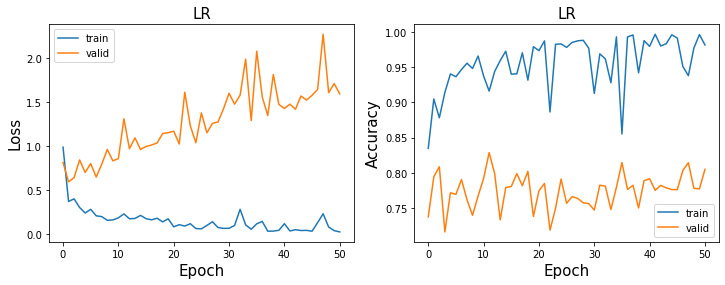

In [5]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.5942504405975342, val accuracy:0.7943984723106302, val percentage postive:0.7856460809707642


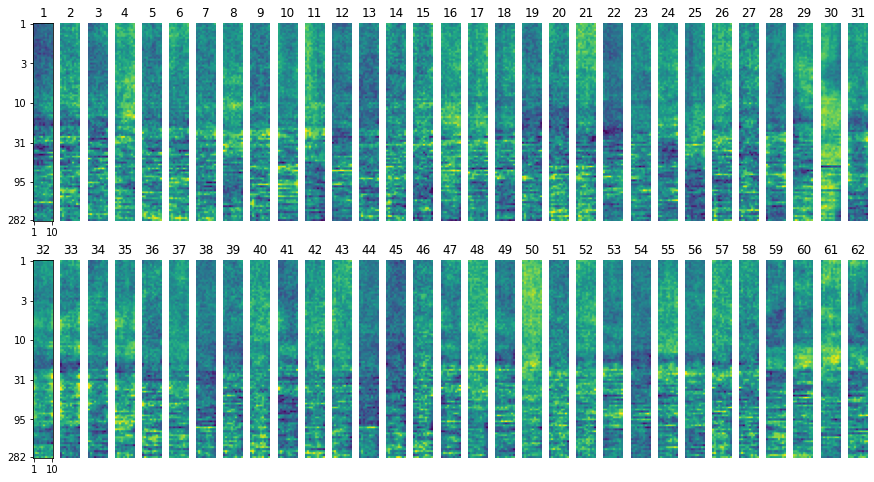

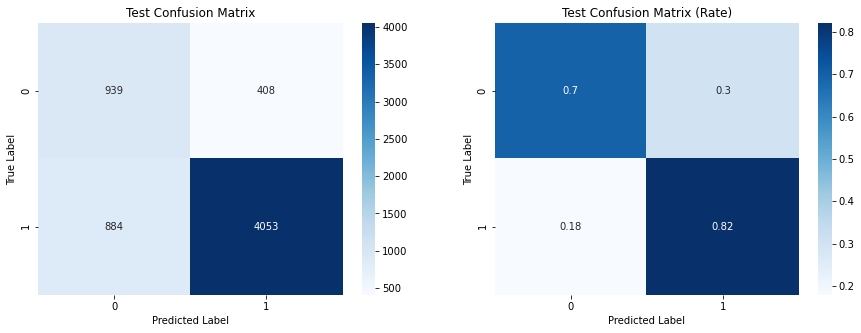

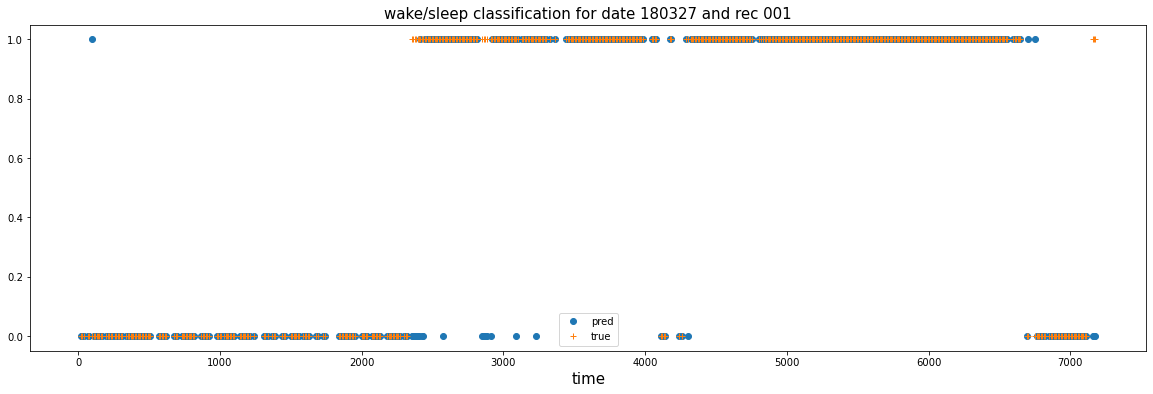

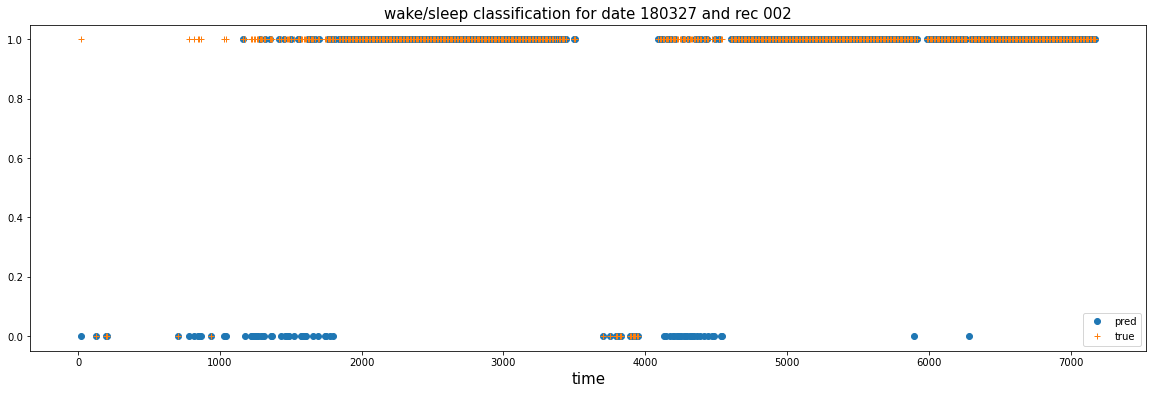

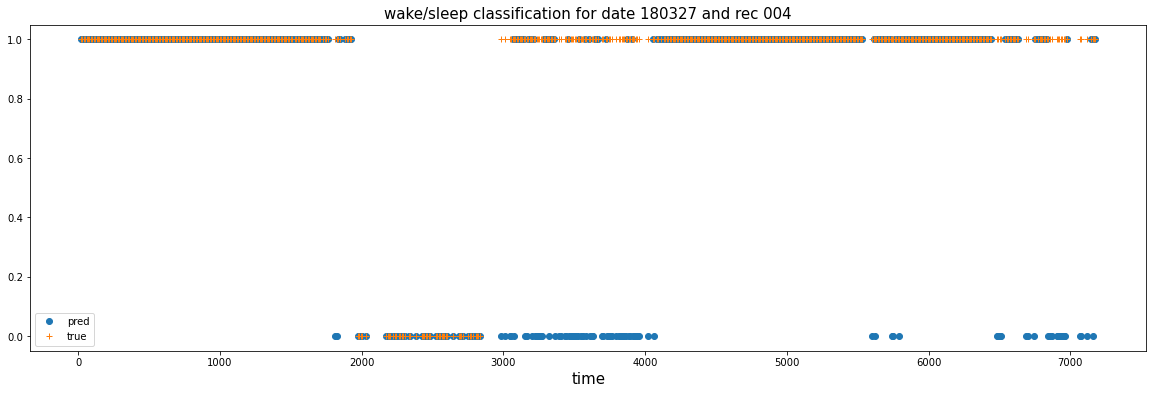

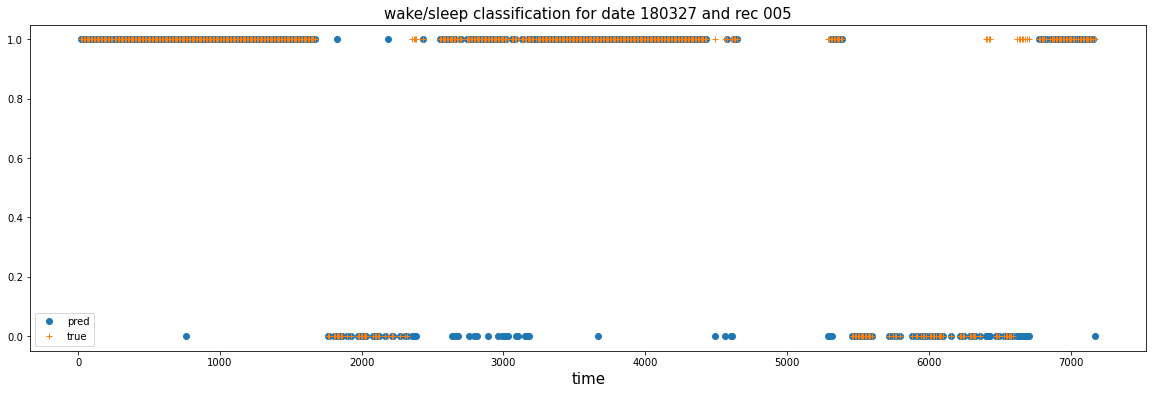

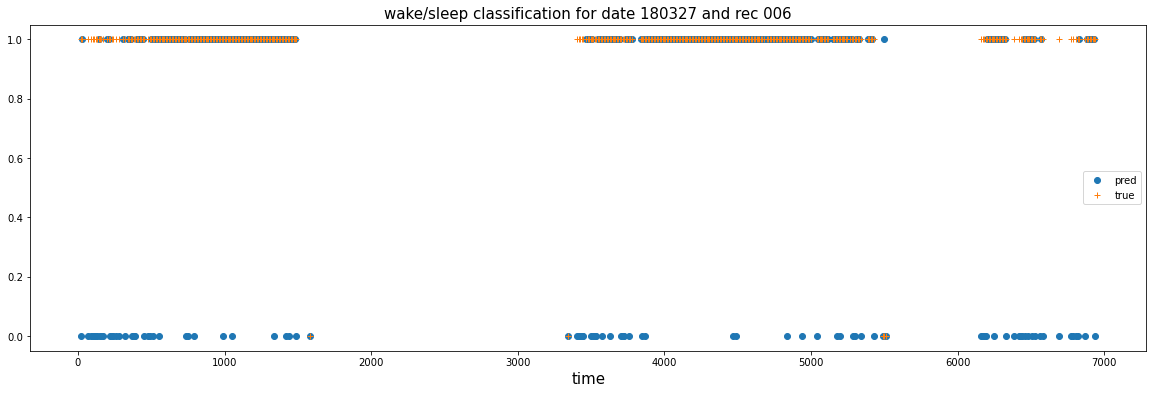

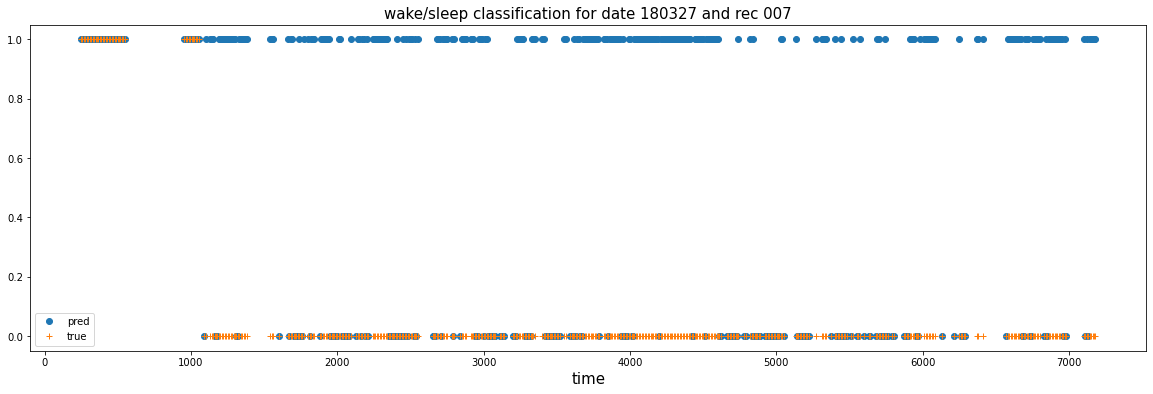

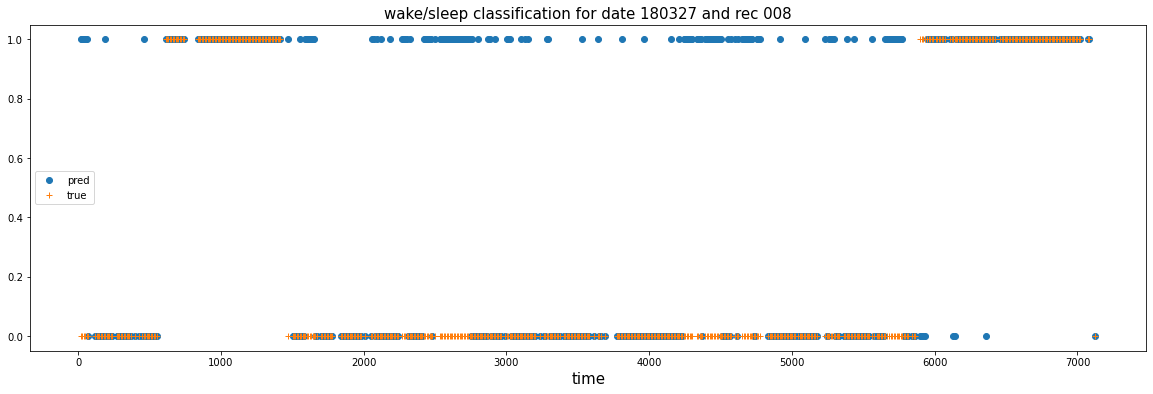

In [22]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.12475379556417465, train accuracy:0.9751392405063292, train percentage postive:0.5


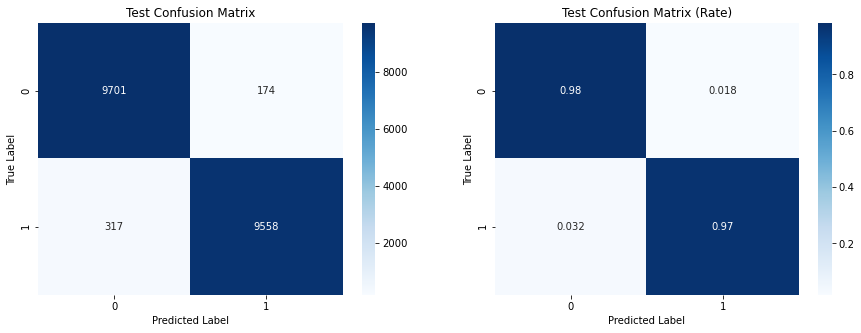

In [23]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [33]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 0.8816252946853638
Val loss for epoch 0: 0.6553778648376465
3
Train loss for epoch 3: 0.3414466679096222
Val loss for epoch 3: 0.5706522464752197


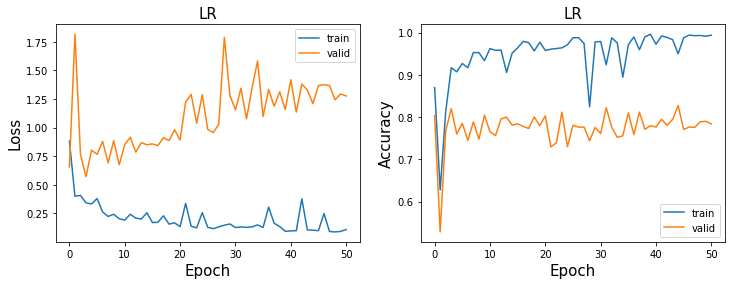

0
Train loss for epoch 0: 1.0076991319656372
Val loss for epoch 0: 0.6403802633285522
1
Train loss for epoch 1: 0.6207325458526611
Val loss for epoch 1: 0.5887036919593811
2
Train loss for epoch 2: 0.6512089967727661
Val loss for epoch 2: 0.5729796290397644
14
Train loss for epoch 14: 0.6967934966087341
Val loss for epoch 14: 0.5490957498550415
17
Train loss for epoch 17: 0.5875641703605652
Val loss for epoch 17: 0.4913252592086792
18
Train loss for epoch 18: 0.562205970287323
Val loss for epoch 18: 0.4674060344696045


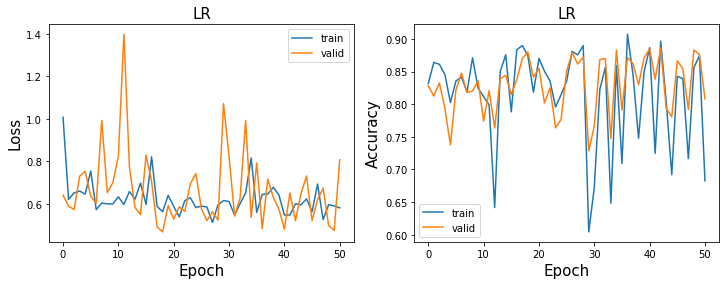

0
Train loss for epoch 0: 1.0962048768997192
Val loss for epoch 0: 0.6898733377456665
1
Train loss for epoch 1: 0.7618489861488342
Val loss for epoch 1: 0.689619779586792
2
Train loss for epoch 2: 0.7987751960754395
Val loss for epoch 2: 0.5929060578346252
5
Train loss for epoch 5: 0.733809769153595
Val loss for epoch 5: 0.5646494626998901
13
Train loss for epoch 13: 0.7204877138137817
Val loss for epoch 13: 0.5198510885238647
30
Train loss for epoch 30: 0.613067626953125
Val loss for epoch 30: 0.49884024262428284


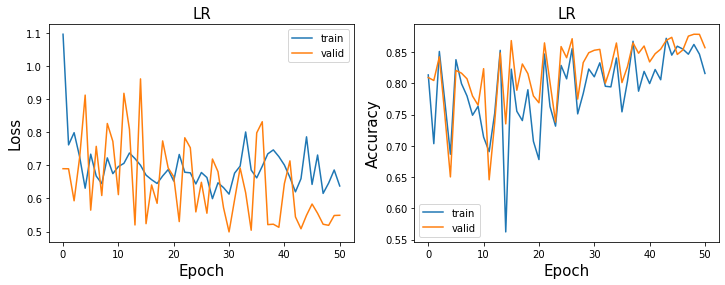

In [25]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.4674060344696045, val accuracy:0.8798535964353915, val percentage postive:0.7856460809707642


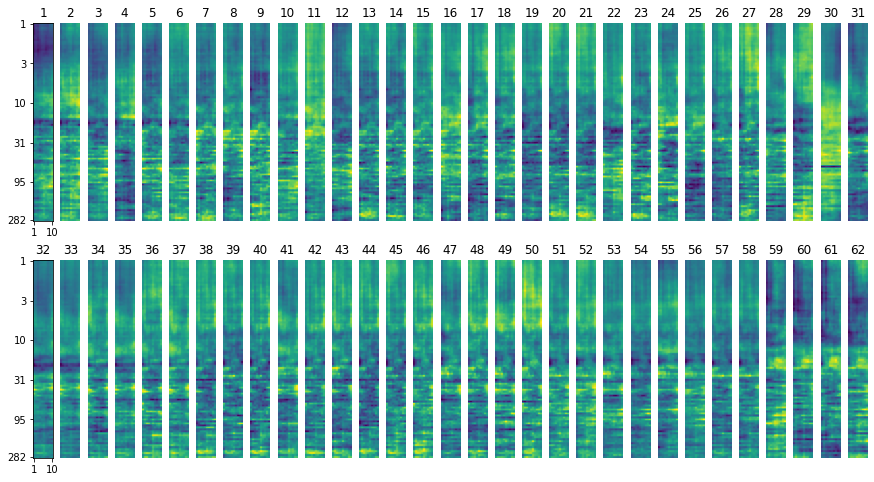

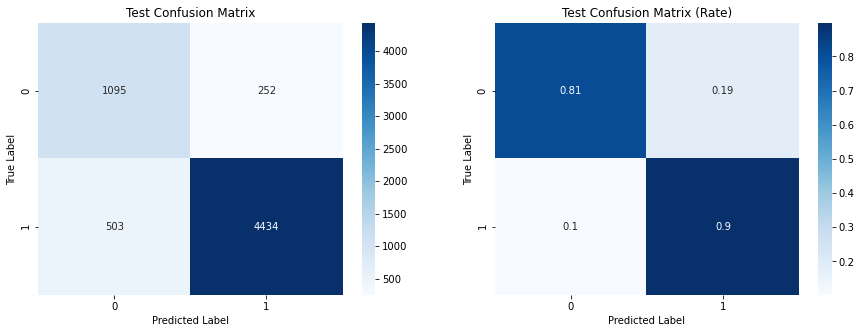

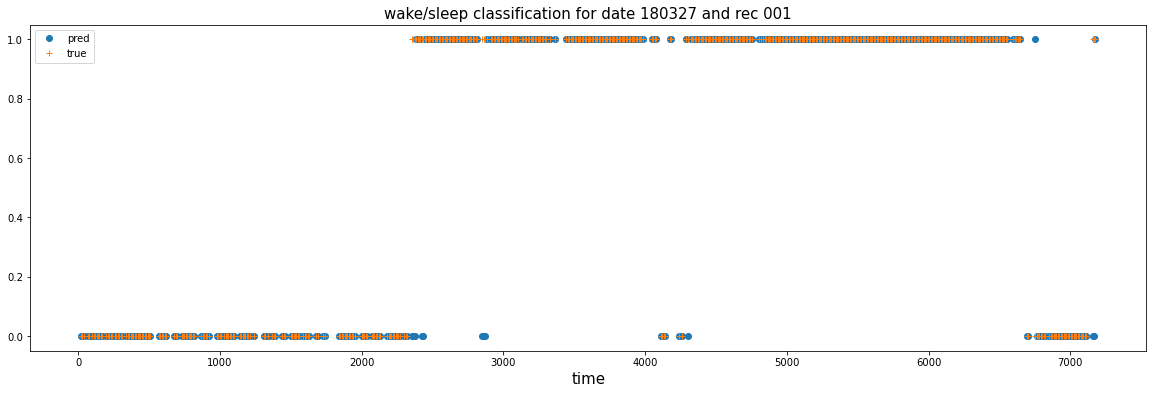

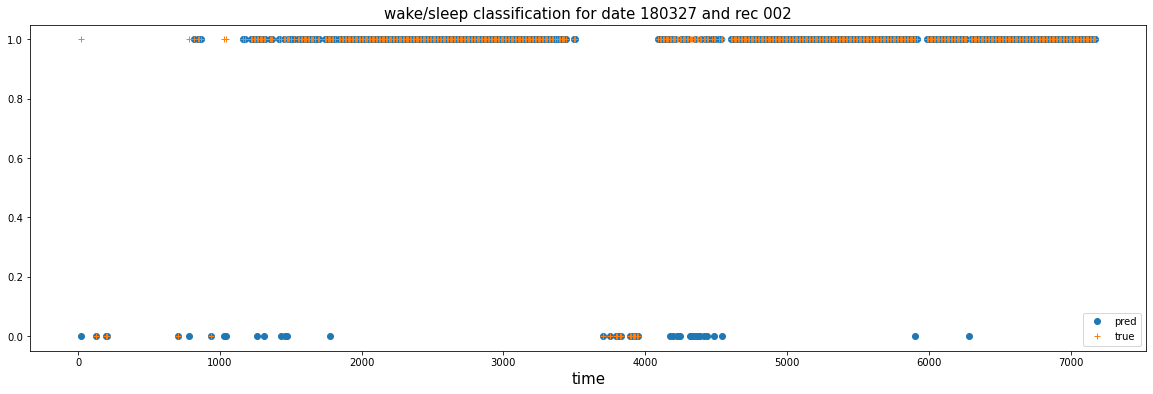

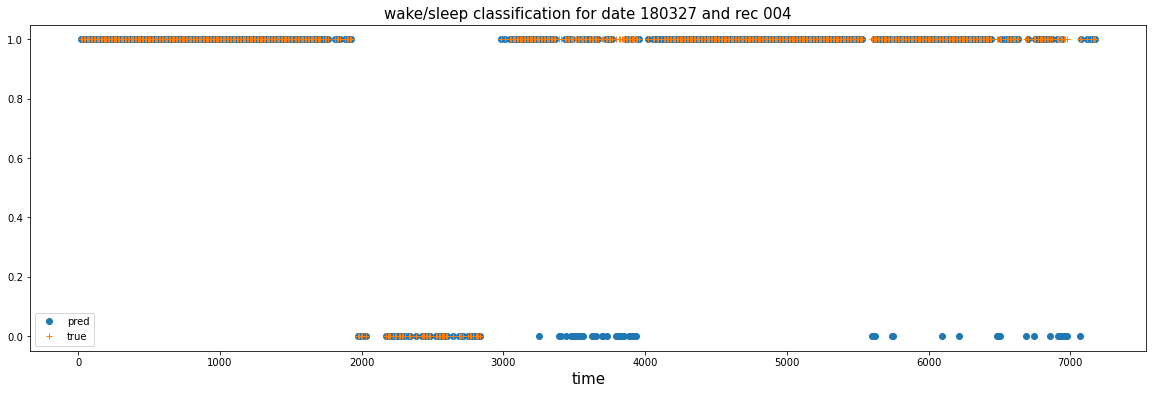

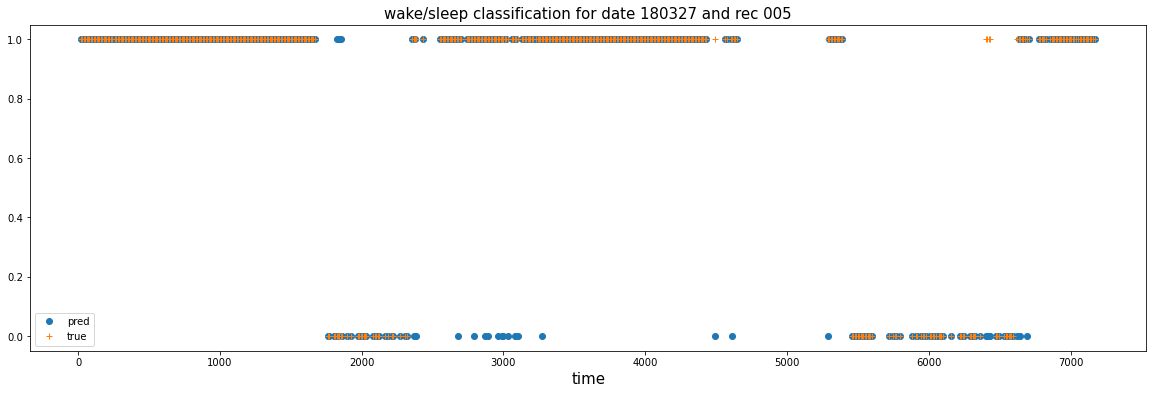

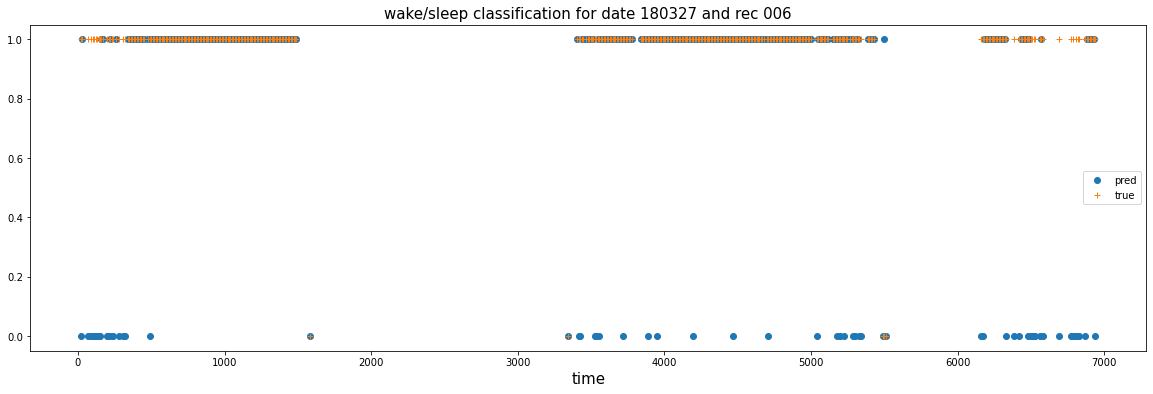

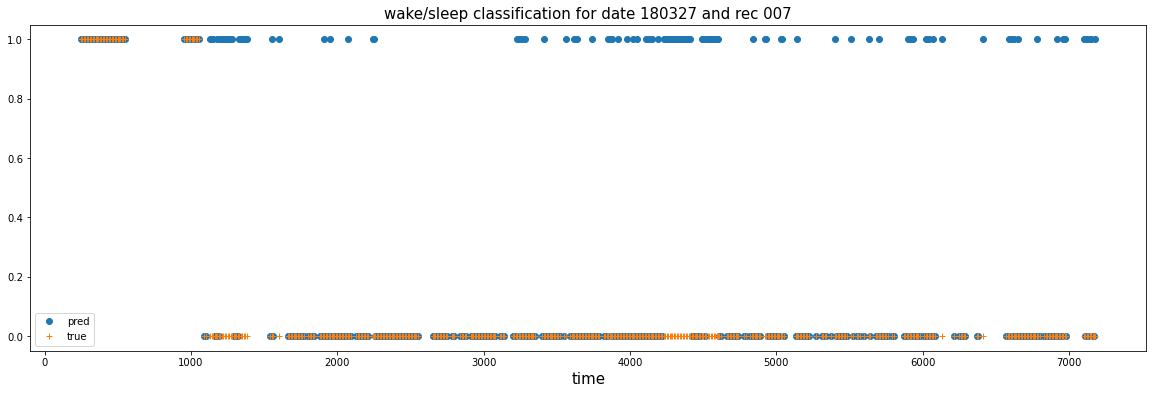

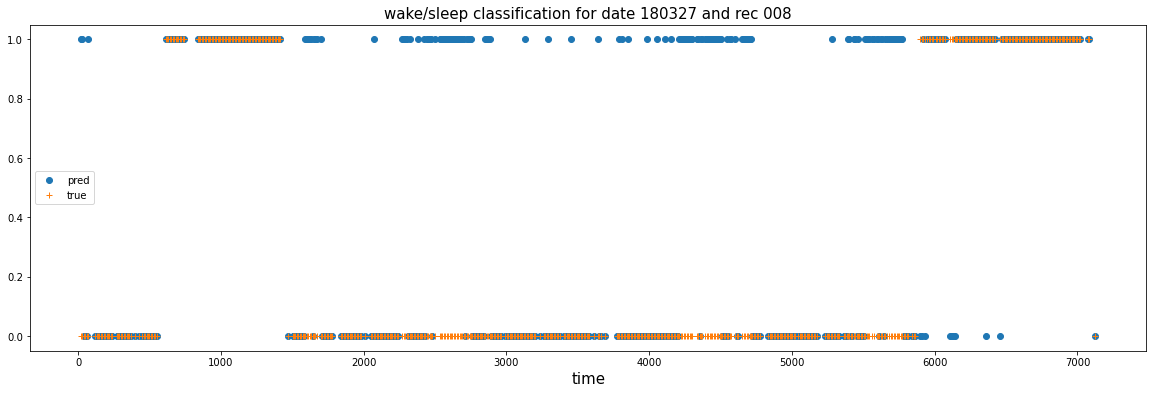

In [37]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.6007508635520935, train accuracy:0.8156962025316455, train percentage postive:0.5


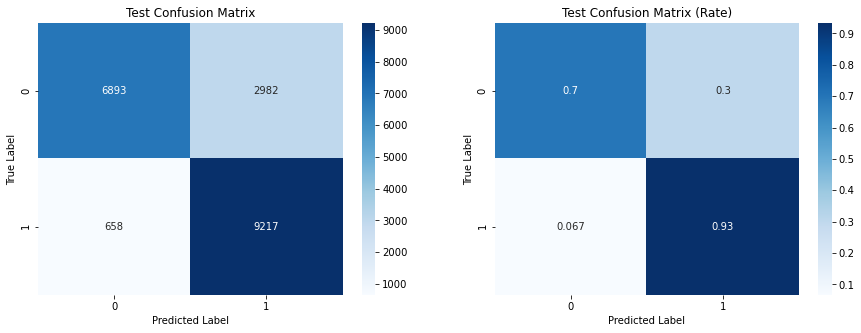

In [38]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [39]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'
time_window = 10

0
Train loss for epoch 0: 0.8950875401496887
Val loss for epoch 0: 0.574050784111023


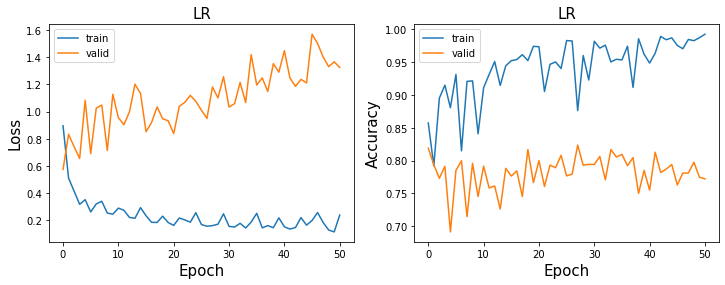

0
Train loss for epoch 0: 1.040626049041748
Val loss for epoch 0: 0.9171745777130127
2
Train loss for epoch 2: 0.5605084896087646
Val loss for epoch 2: 0.6119969487190247
4
Train loss for epoch 4: 0.49284040927886963
Val loss for epoch 4: 0.6066471934318542
12
Train loss for epoch 12: 0.5436195135116577
Val loss for epoch 12: 0.5492432713508606
23
Train loss for epoch 23: 0.4340433180332184
Val loss for epoch 23: 0.5397502779960632
37
Train loss for epoch 37: 0.5060698986053467
Val loss for epoch 37: 0.5387988090515137
40
Train loss for epoch 40: 0.4890359044075012
Val loss for epoch 40: 0.5296761989593506


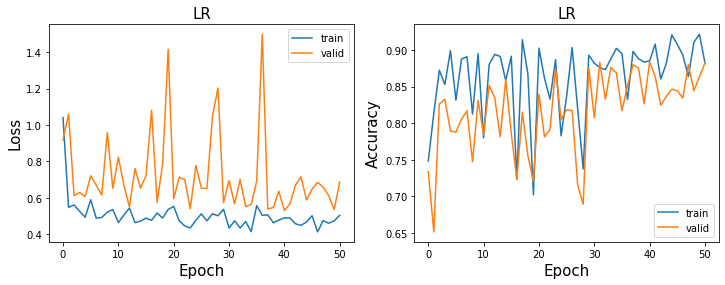

0
Train loss for epoch 0: 1.0007741451263428
Val loss for epoch 0: 0.5523314476013184
17
Train loss for epoch 17: 0.515569806098938
Val loss for epoch 17: 0.5506105422973633
18
Train loss for epoch 18: 0.5081061720848083
Val loss for epoch 18: 0.534521222114563
24
Train loss for epoch 24: 0.4811798334121704
Val loss for epoch 24: 0.5206660628318787
31
Train loss for epoch 31: 0.48501771688461304
Val loss for epoch 31: 0.5175351500511169
34
Train loss for epoch 34: 0.47807398438453674
Val loss for epoch 34: 0.5084560513496399


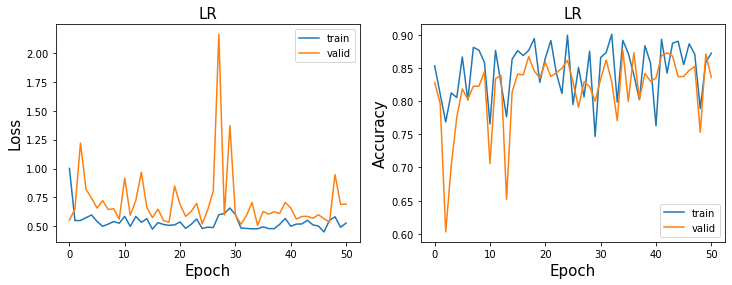

In [40]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.5084560513496399, val accuracy:0.8768300445576066, val percentage postive:0.7856460809707642


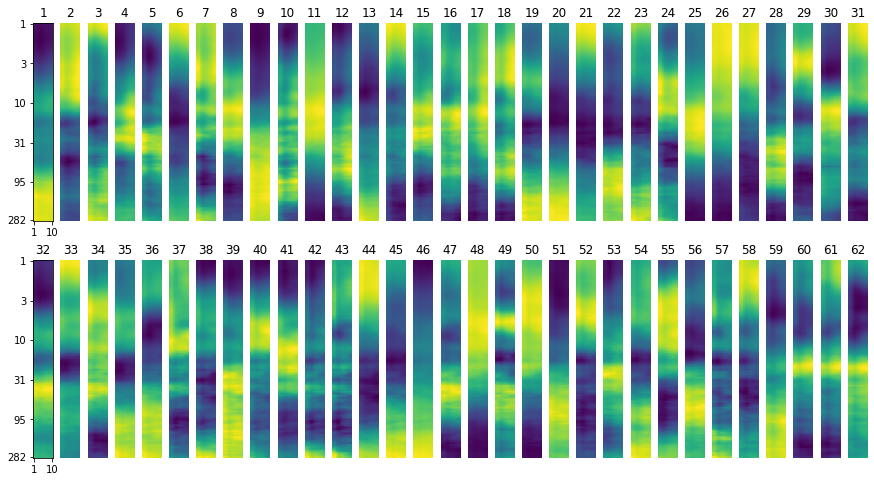

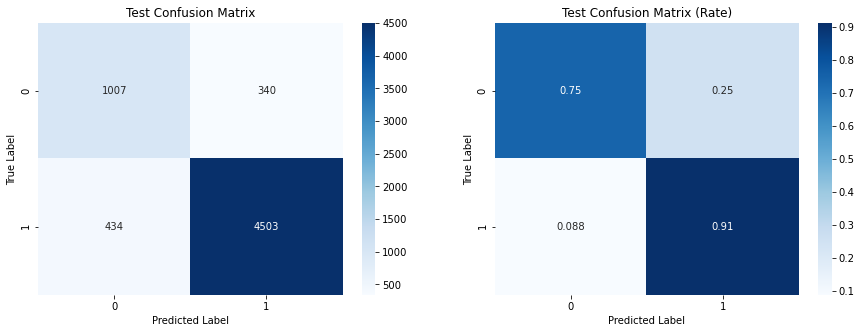

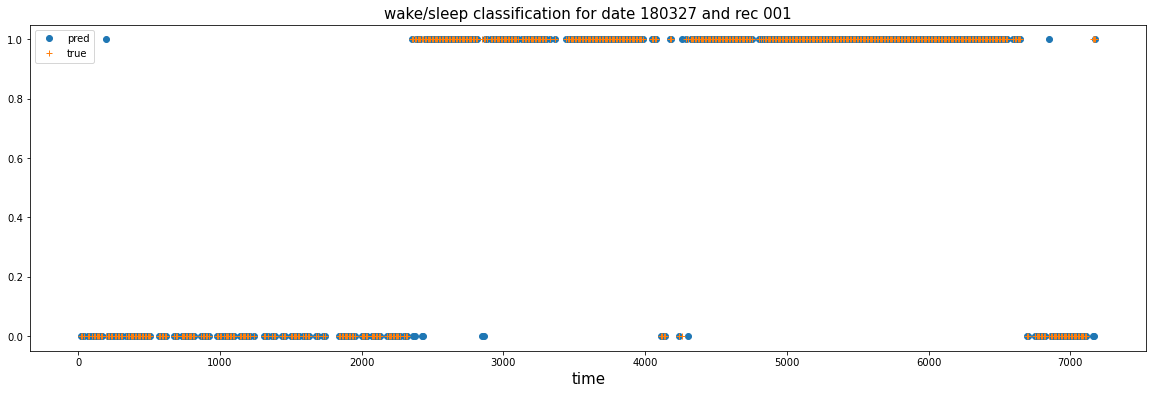

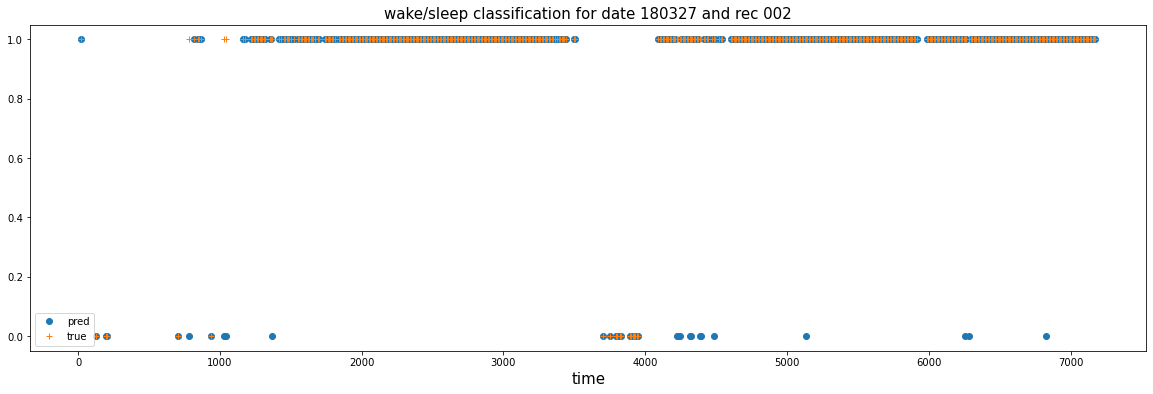

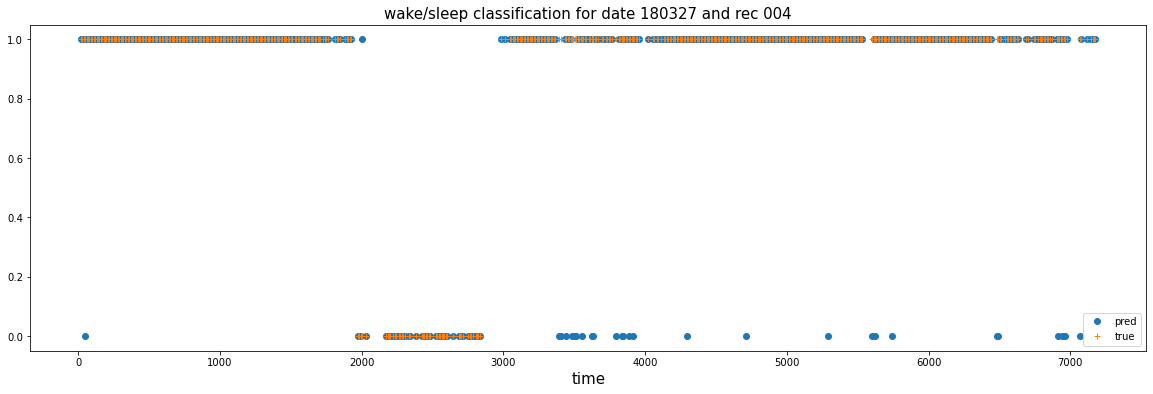

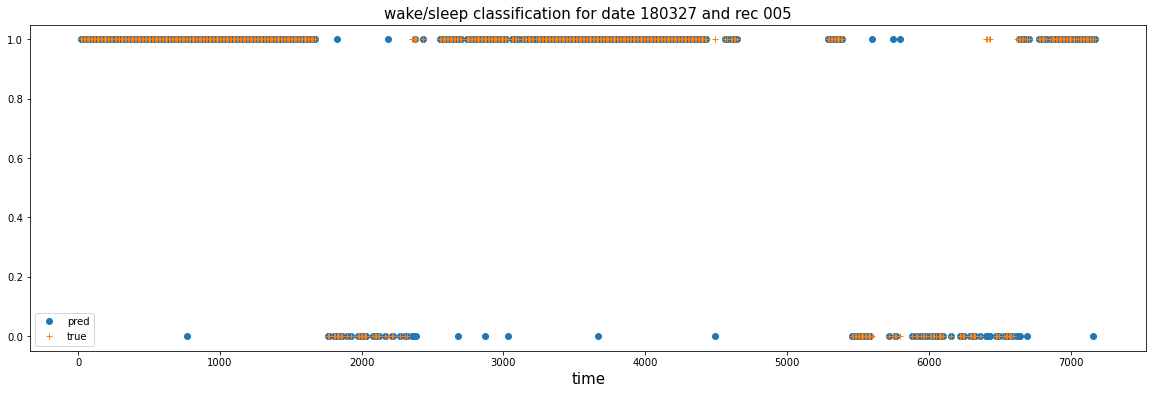

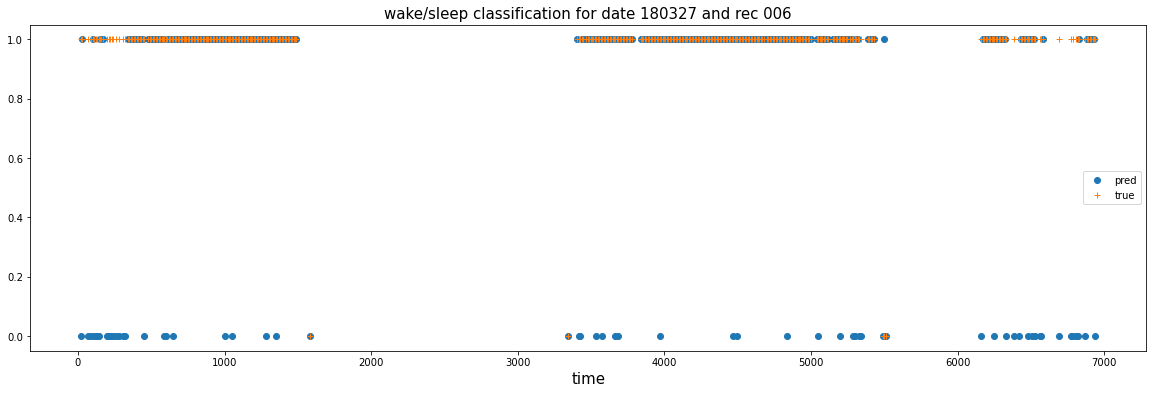

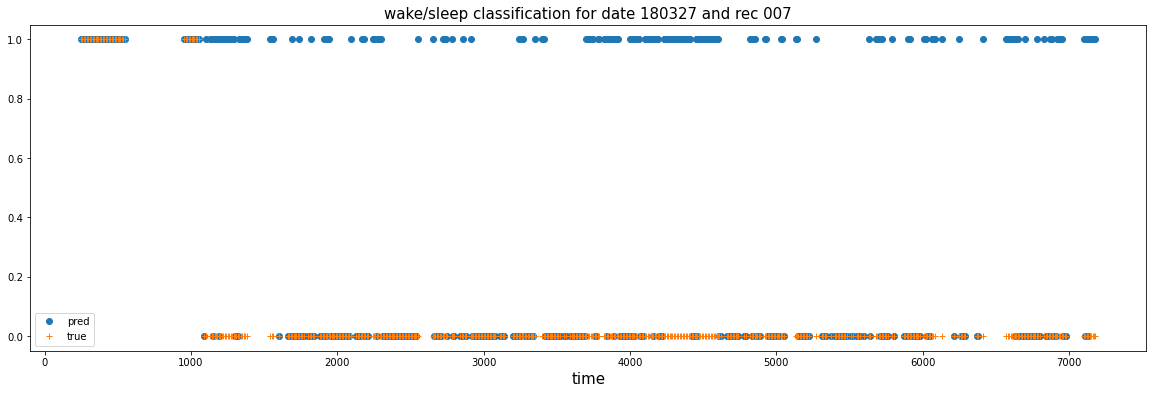

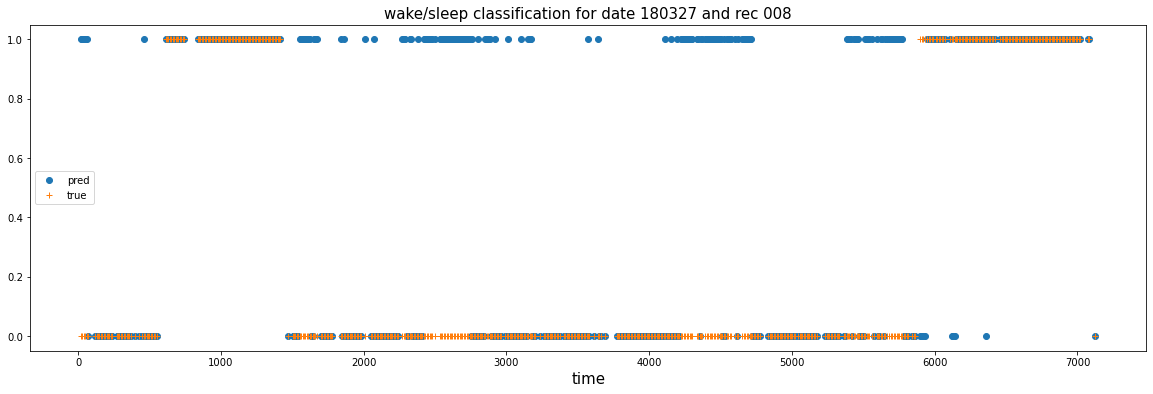

In [41]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.502096951007843, train accuracy:0.872253164556962, train percentage postive:0.5


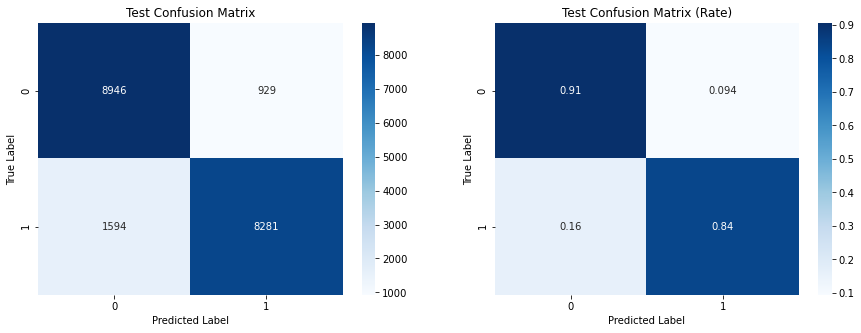

In [42]:
model = GLM().to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

### LR, 62CH, 5S

In [14]:
CH = 'all'
time_window = 5
device = torch.device('cuda')

val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_5s_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=128)

val dates: ['180327', '180329'], test dates: ['180330', '180331']
val instances: 13272, val imbalance: 0.7787824273109436
test instances: 13244, test imbalance: 0.7352763414382935
train instances: 41068, train imbalance: 0.5


#### Without regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM(input_dim=100*time_window*62).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 0.5049217343330383
Val loss for epoch 0: 0.45709455013275146


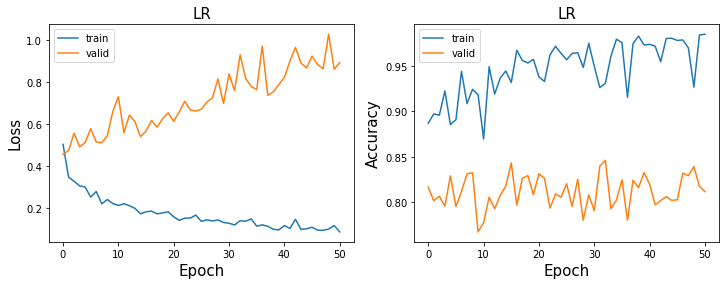

In [62]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.45709455013275146, val accuracy:0.8166817359855335, val percentage postive:0.7787824273109436


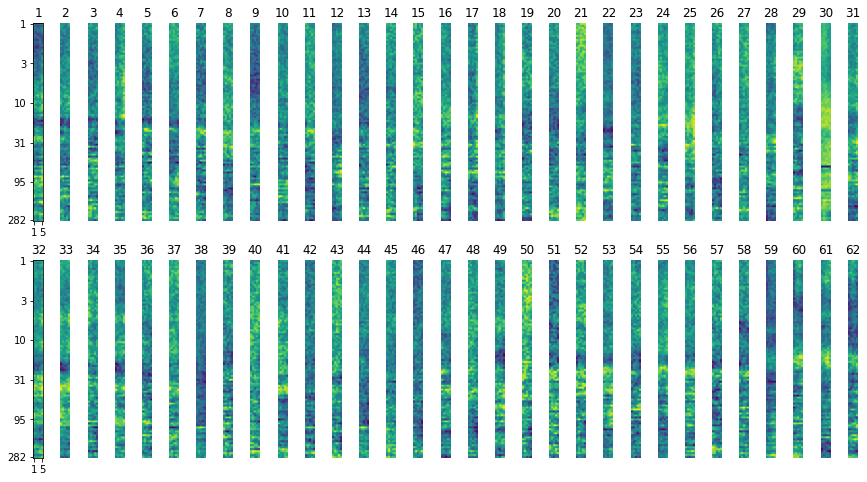

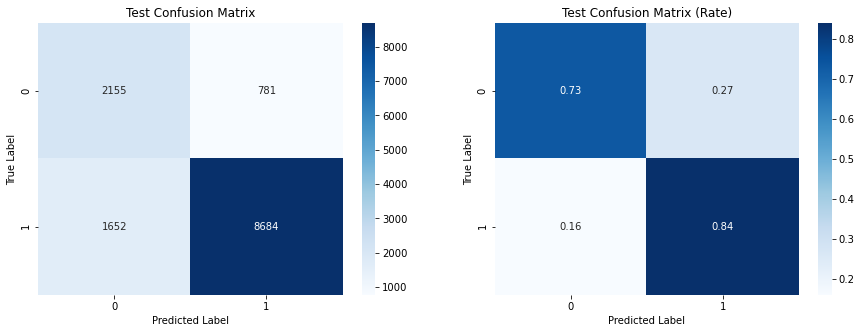

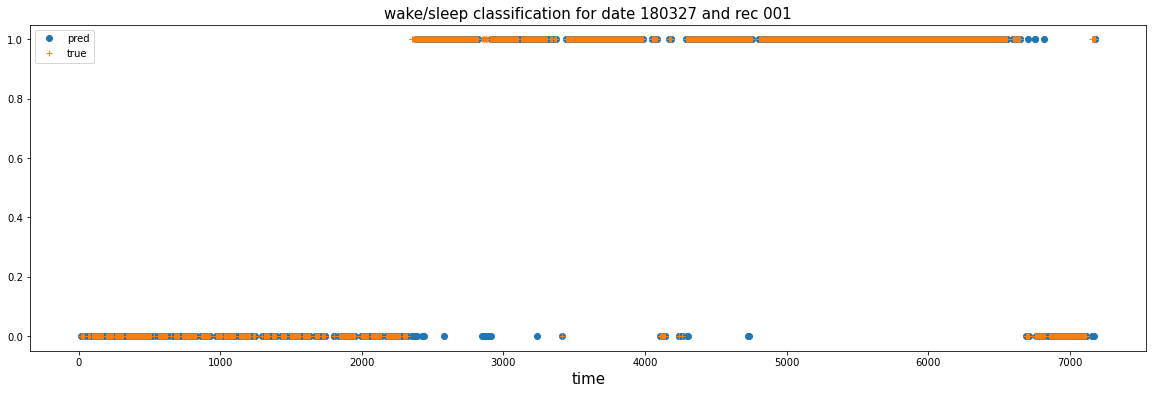

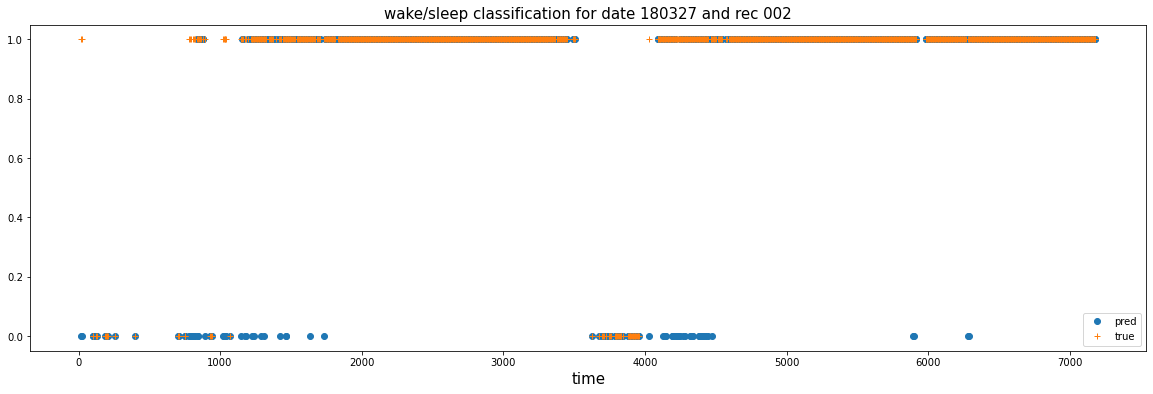

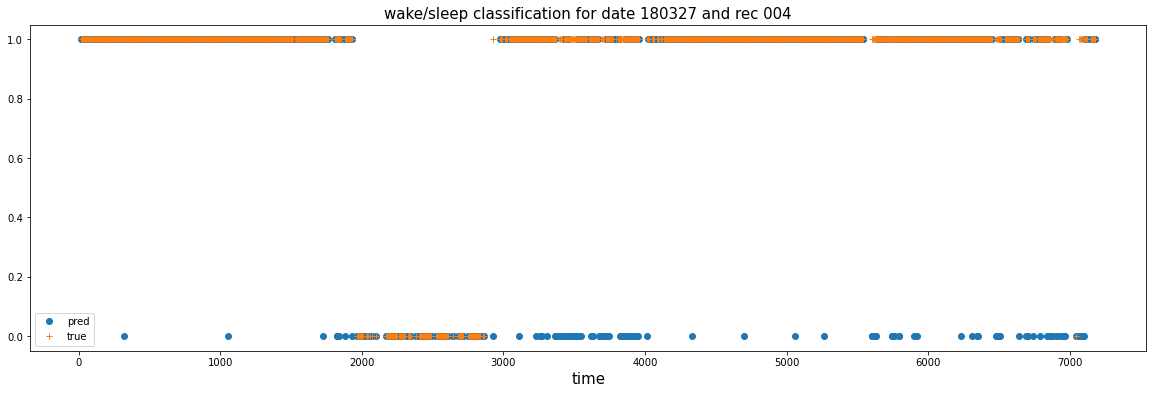

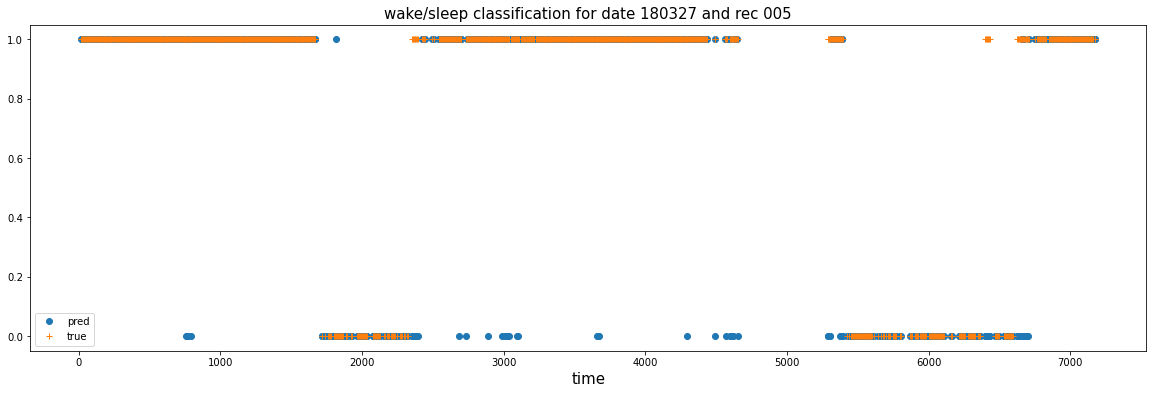

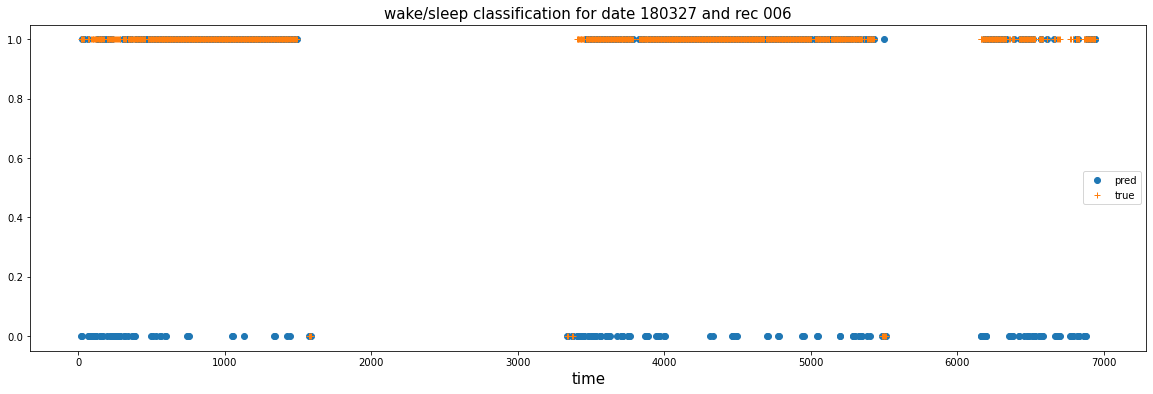

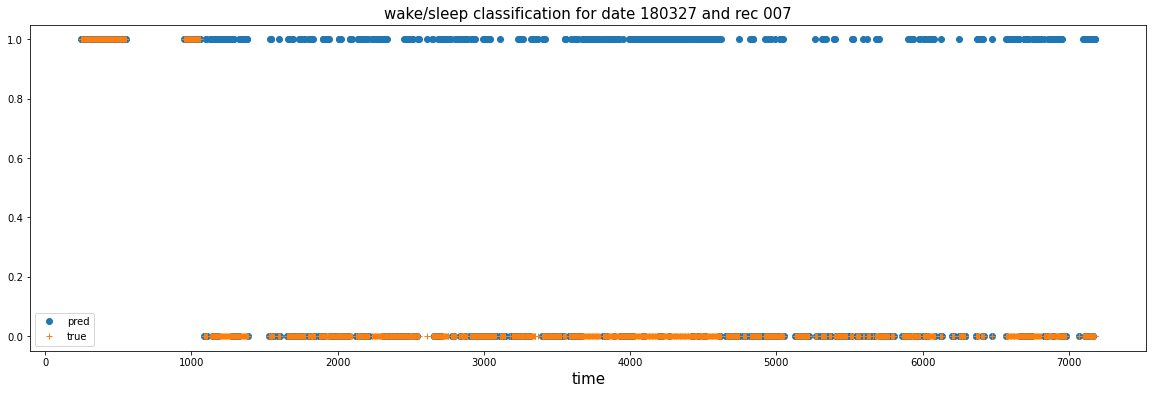

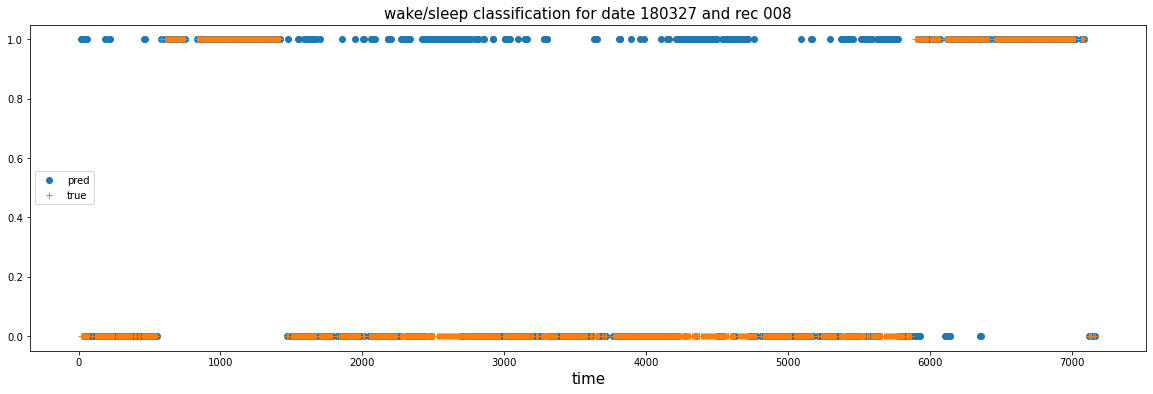

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.08807075023651123, train accuracy:0.9798870166553034, train percentage postive:0.5


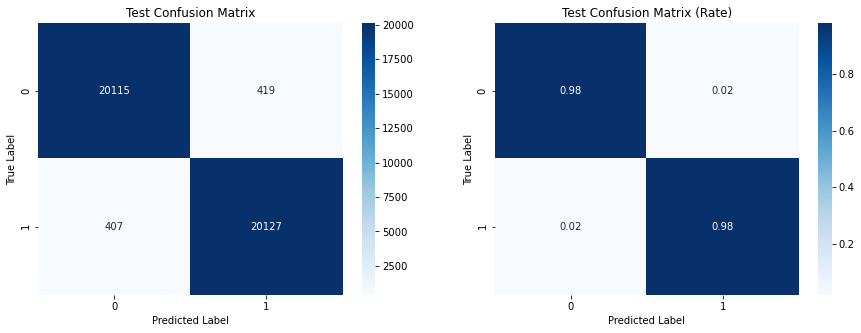

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [7]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 0.5082836151123047
Val loss for epoch 0: 0.5350350737571716
2
Train loss for epoch 2: 0.329218327999115
Val loss for epoch 2: 0.5083081126213074
3
Train loss for epoch 3: 0.32624271512031555
Val loss for epoch 3: 0.492893248796463


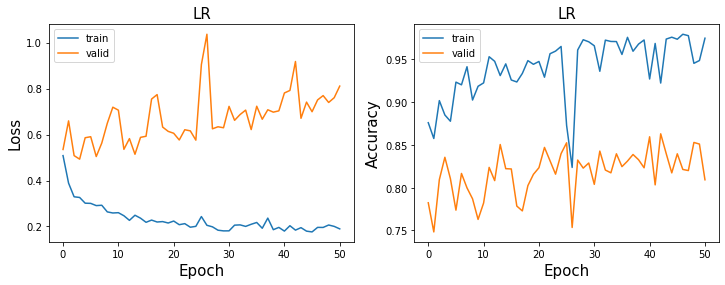

0
Train loss for epoch 0: 0.6597583889961243
Val loss for epoch 0: 0.7763242125511169
1
Train loss for epoch 1: 0.6025110483169556
Val loss for epoch 1: 0.5766419172286987
2
Train loss for epoch 2: 0.5571439266204834
Val loss for epoch 2: 0.5036622285842896
5
Train loss for epoch 5: 0.5644950866699219
Val loss for epoch 5: 0.4759393036365509
9
Train loss for epoch 9: 0.5725904107093811
Val loss for epoch 9: 0.4668348431587219
19
Train loss for epoch 19: 0.5479883551597595
Val loss for epoch 19: 0.4520978033542633
29
Train loss for epoch 29: 0.5671103596687317
Val loss for epoch 29: 0.4517136812210083


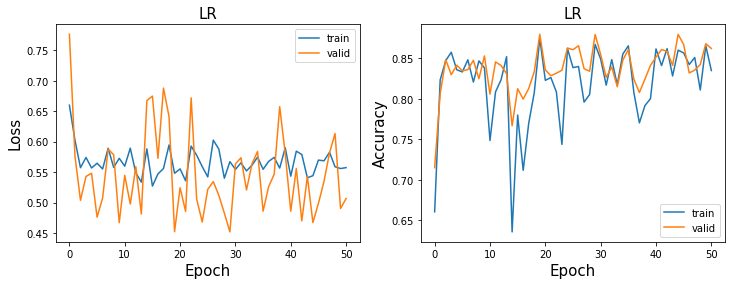

0
Train loss for epoch 0: 0.725829541683197
Val loss for epoch 0: 0.6109916567802429
1
Train loss for epoch 1: 0.6394141912460327
Val loss for epoch 1: 0.5607039928436279
3
Train loss for epoch 3: 0.6107273101806641
Val loss for epoch 3: 0.5351472496986389
5
Train loss for epoch 5: 0.6069586277008057
Val loss for epoch 5: 0.5004533529281616
8
Train loss for epoch 8: 0.6226311326026917
Val loss for epoch 8: 0.49927353858947754
11
Train loss for epoch 11: 0.6038218140602112
Val loss for epoch 11: 0.4832307696342468
20
Train loss for epoch 20: 0.6149115562438965
Val loss for epoch 20: 0.4650472402572632


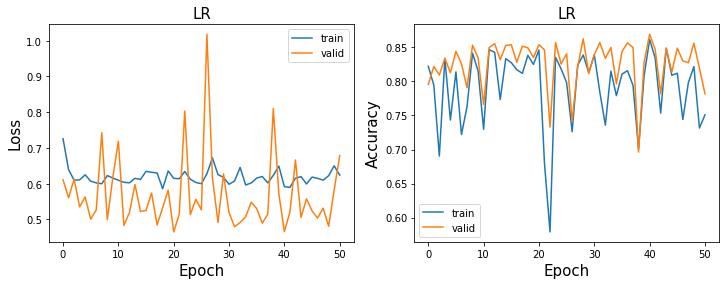

In [8]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.4517136812210083, val accuracy:0.8793701024713683, val percentage postive:0.7787824273109436


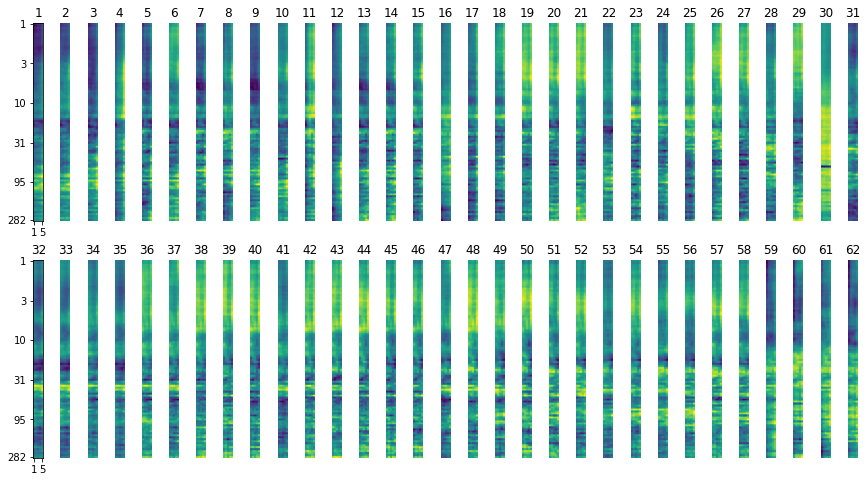

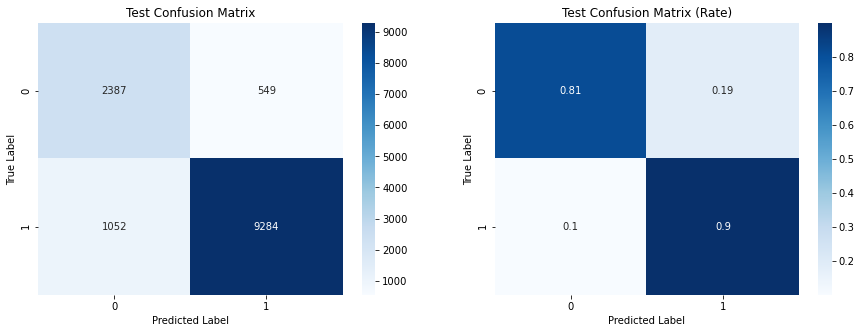

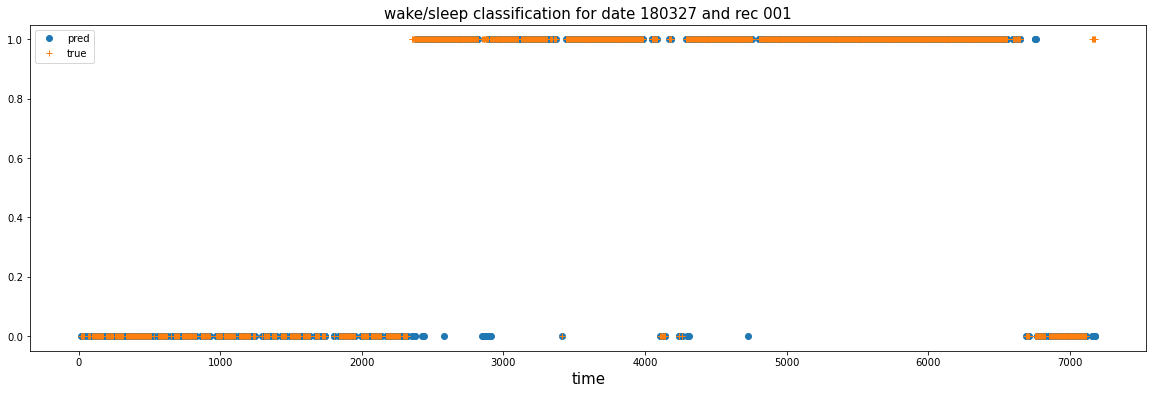

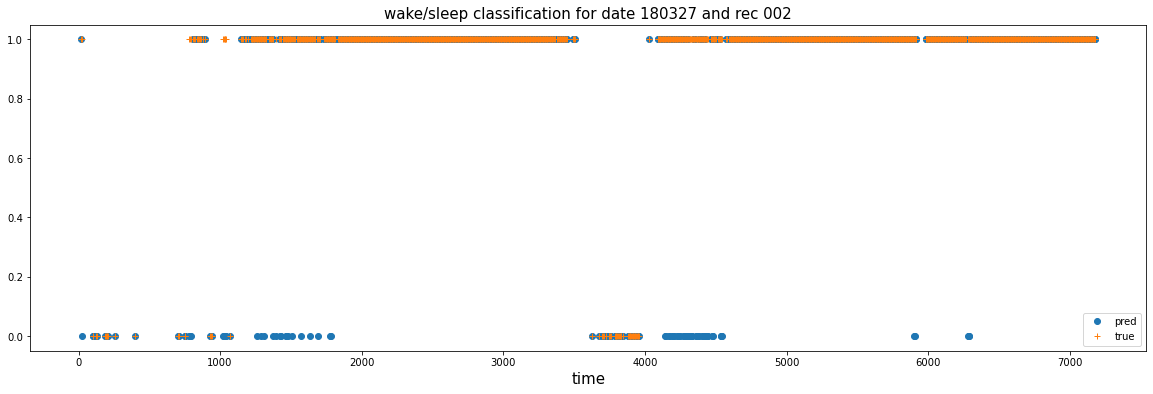

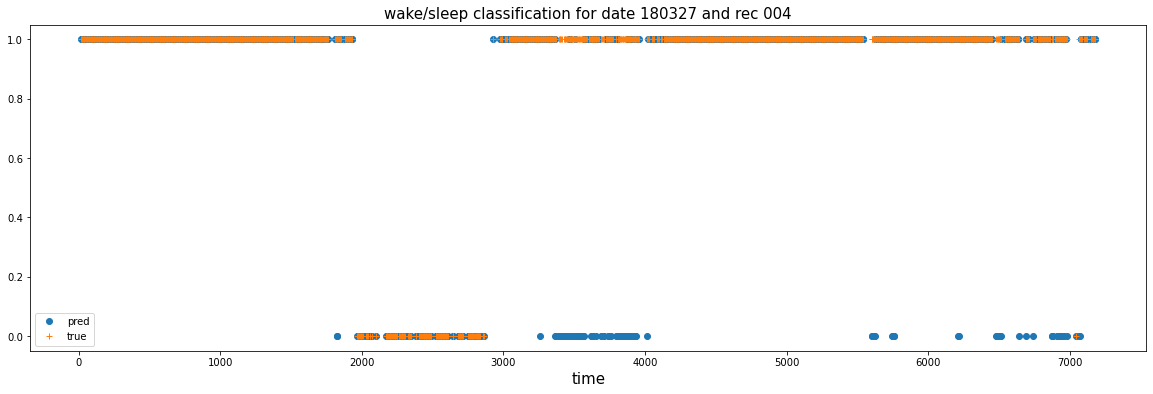

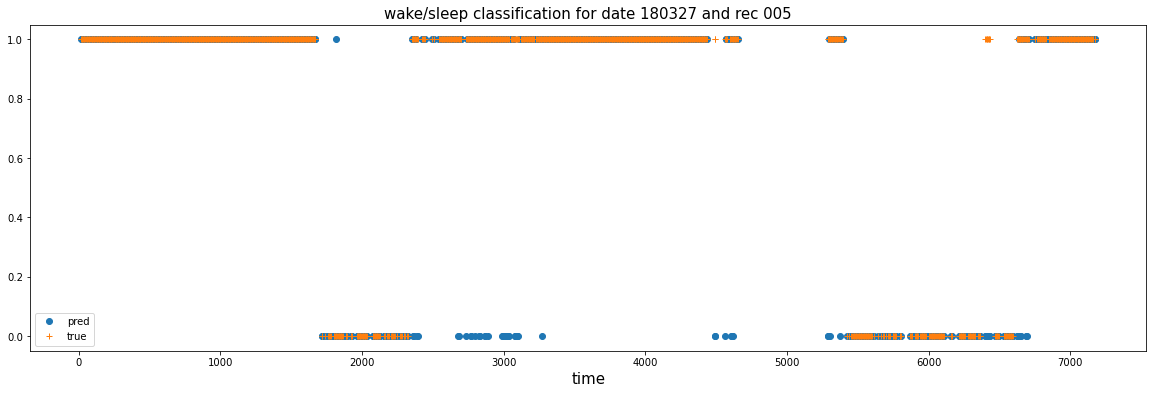

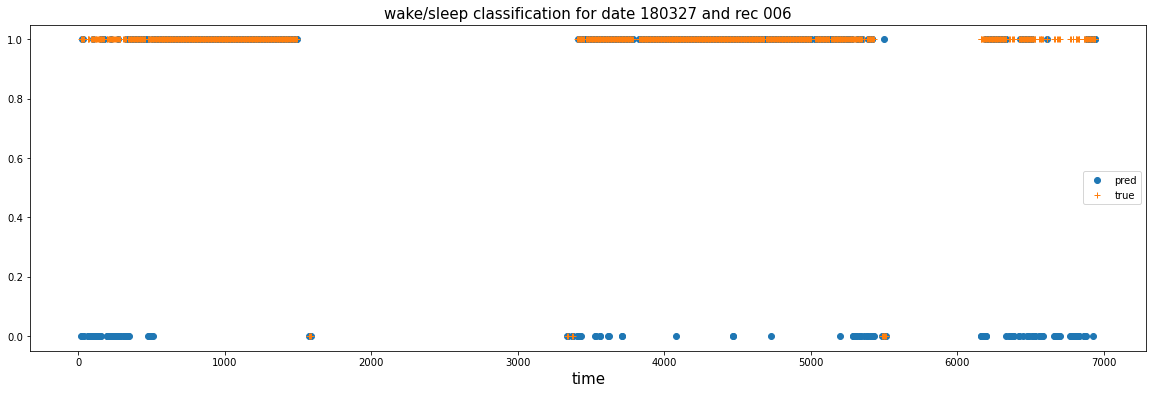

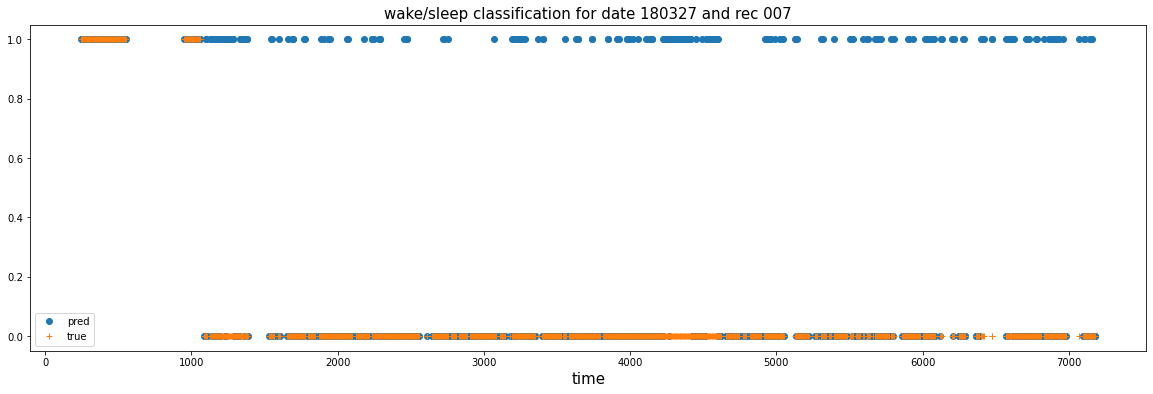

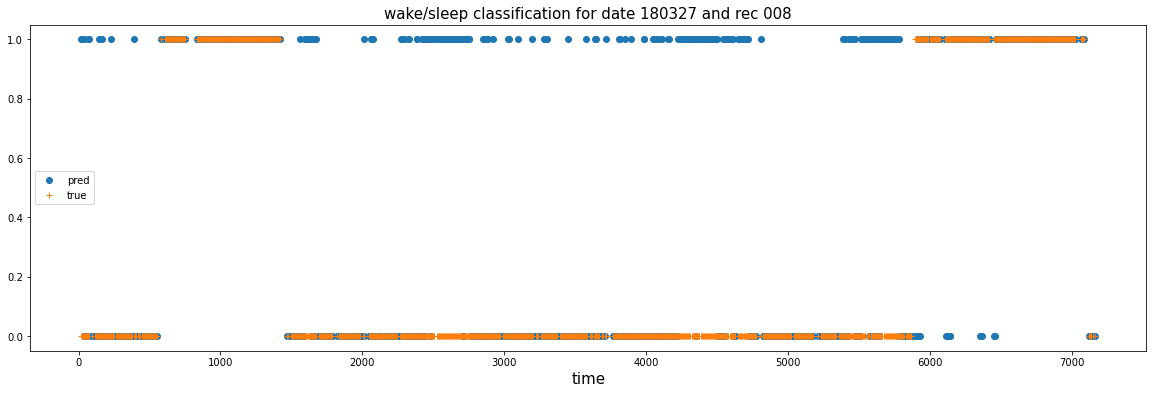

In [9]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.736582338809967, train accuracy:0.7508522450569787, train percentage postive:0.5


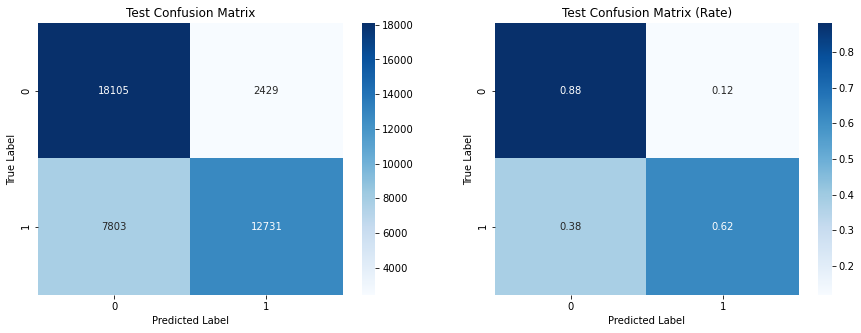

In [10]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [3]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'

0
Train loss for epoch 0: 0.4929482340812683
Val loss for epoch 0: 0.4725939929485321


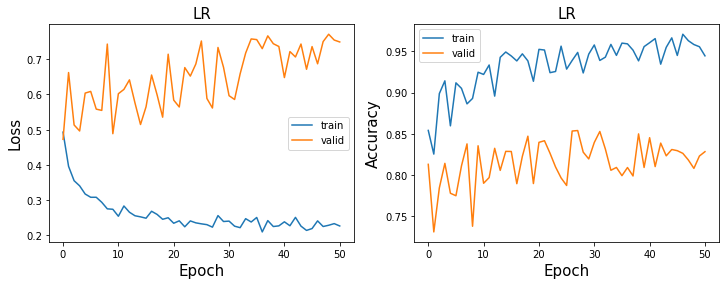

0
Train loss for epoch 0: 0.5969903469085693
Val loss for epoch 0: 0.5214177966117859
1
Train loss for epoch 1: 0.49316632747650146
Val loss for epoch 1: 0.48322010040283203
5
Train loss for epoch 5: 0.45493564009666443
Val loss for epoch 5: 0.4556831419467926
8
Train loss for epoch 8: 0.4385402798652649
Val loss for epoch 8: 0.4491444230079651
23
Train loss for epoch 23: 0.4720892906188965
Val loss for epoch 23: 0.4332025647163391


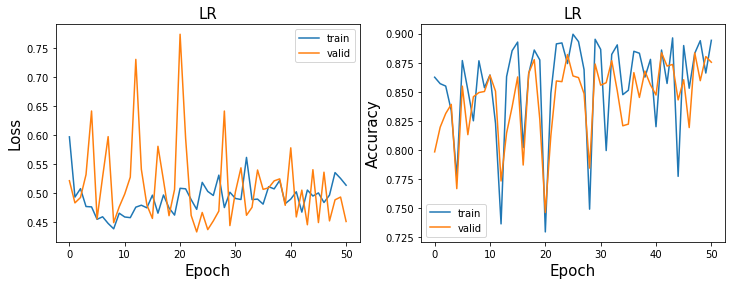

0
Train loss for epoch 0: 0.6056838631629944
Val loss for epoch 0: 0.5279271006584167
1
Train loss for epoch 1: 0.49098891019821167
Val loss for epoch 1: 0.504608690738678
4
Train loss for epoch 4: 0.517510175704956
Val loss for epoch 4: 0.47482648491859436
11
Train loss for epoch 11: 0.5076421499252319
Val loss for epoch 11: 0.4738823175430298
13
Train loss for epoch 13: 0.4973599314689636
Val loss for epoch 13: 0.4289557635784149
15
Train loss for epoch 15: 0.4899548590183258
Val loss for epoch 15: 0.42891696095466614
33
Train loss for epoch 33: 0.5387601852416992
Val loss for epoch 33: 0.42052894830703735


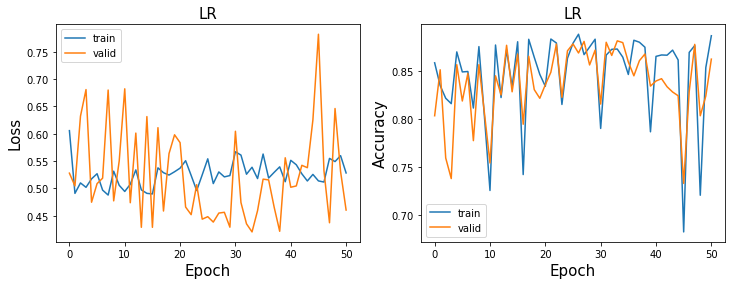

In [4]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.42052894830703735, val accuracy:0.88208257986739, val percentage postive:0.7787824273109436


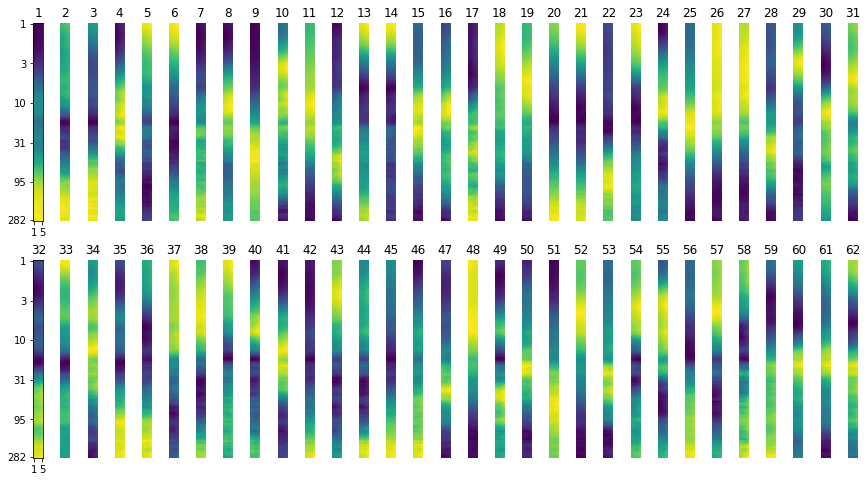

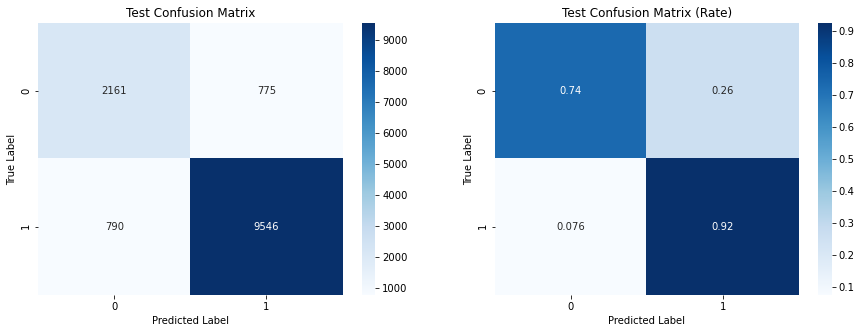

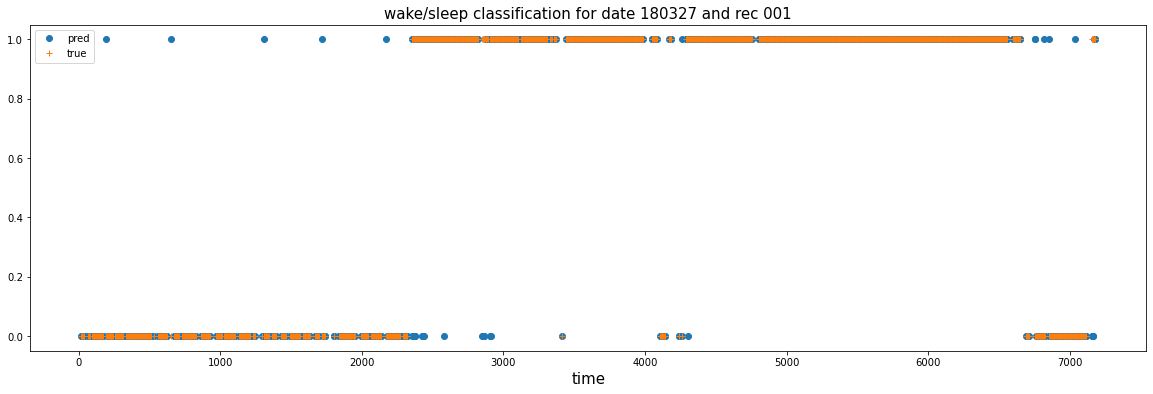

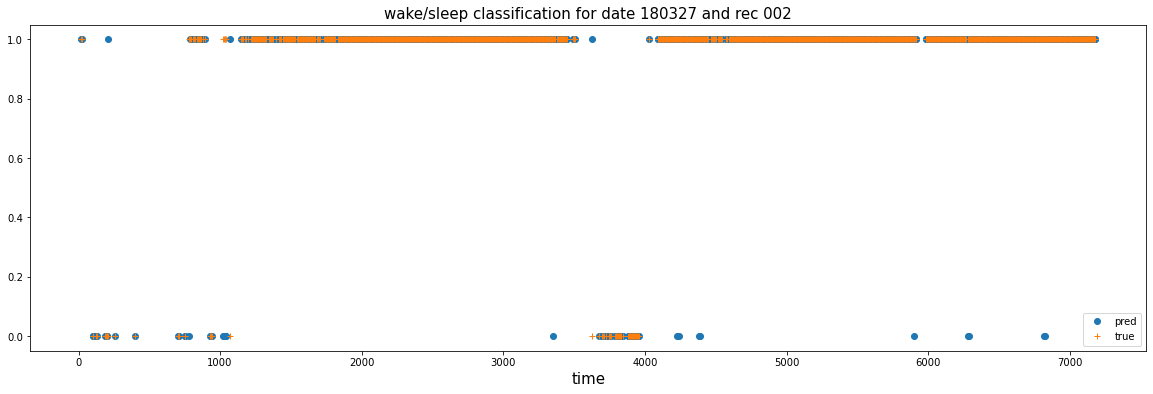

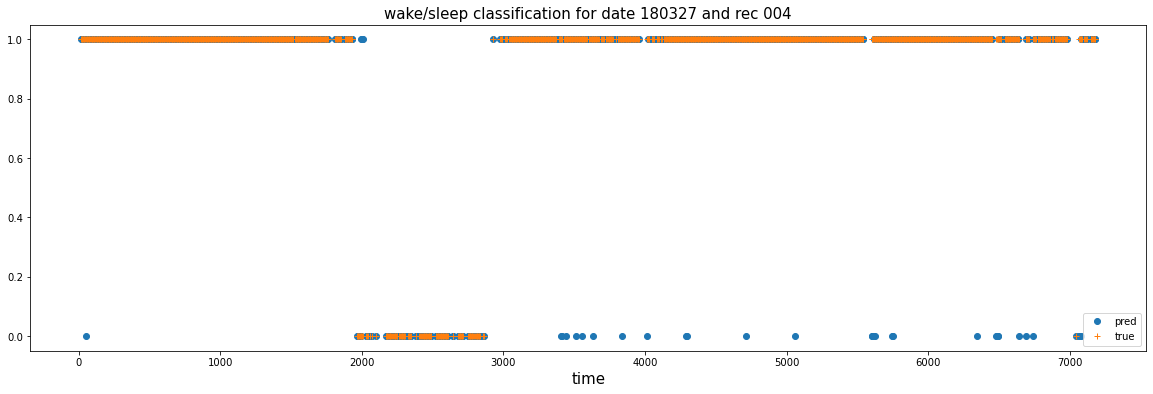

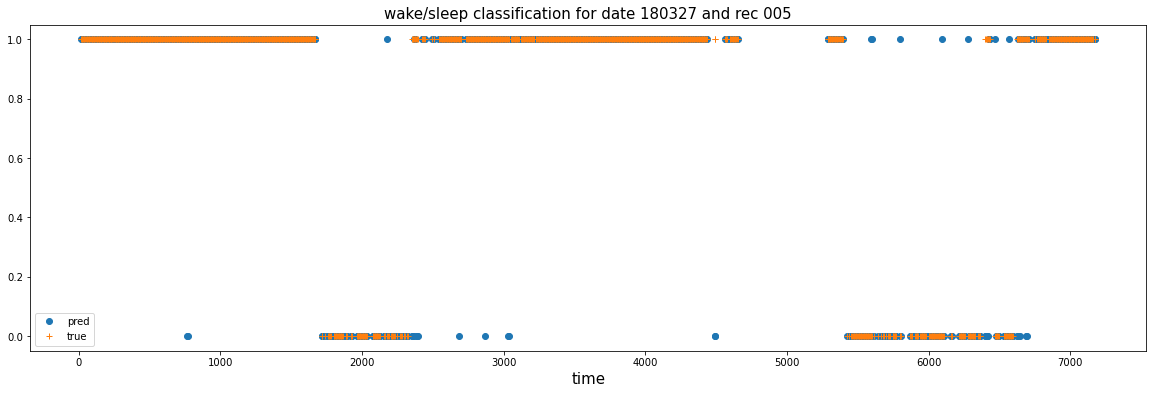

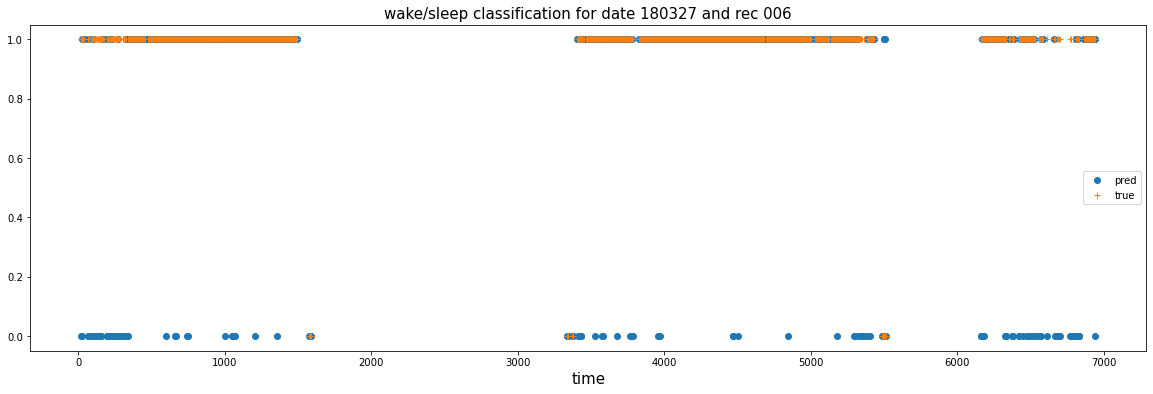

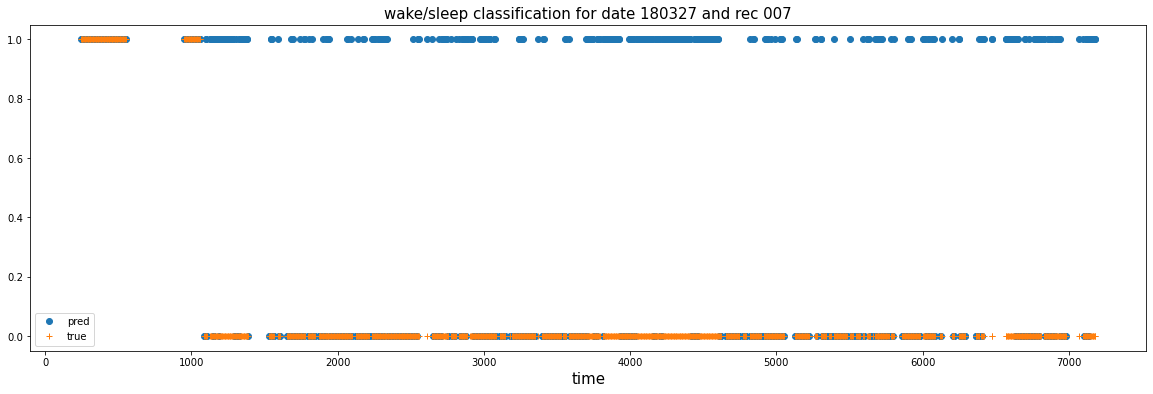

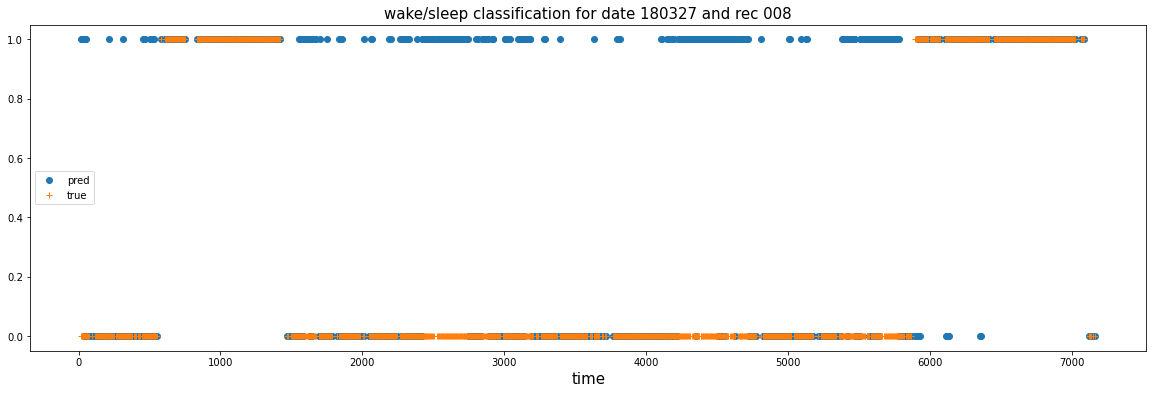

In [5]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.448866605758667, train accuracy:0.8874306029025032, train percentage postive:0.5


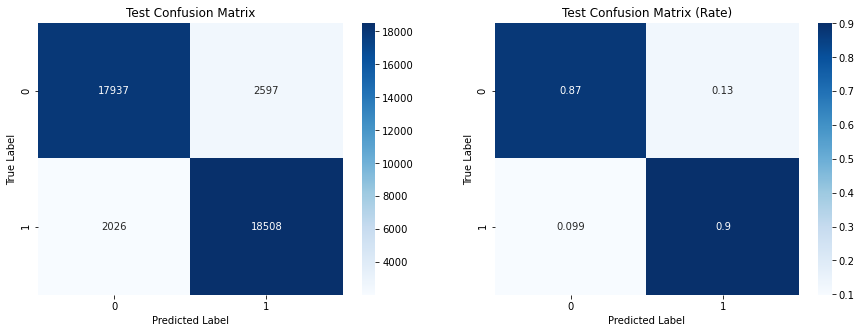

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

### LR, 62CH, 15S

In [3]:
CH = 'all'
time_window = 15
device = torch.device('cuda')

val_dates = ['180327','180329']
test_dates = ['180330','180331']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_15s_2/'
save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_presentation_Yue/model_Goose_1st'

test_imbalance(load_path, val_dates, test_dates, bad_dates, test_train=True)
train_files, val_files, test_files = create_files(load_path, val_dates, test_dates, bad_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files, load_path, batch_size=256)

val dates: ['180327', '180329'], test dates: ['180330', '180331']
val instances: 3931, val imbalance: 0.7914016842842102
test instances: 3899, test imbalance: 0.739676833152771
train instances: 12546, train imbalance: 0.5


#### Without regularization

In [4]:
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'LR'
loss_type = 'bce'
reg_type = 'none'

model = GLM(input_dim=100*time_window*62).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

0
Train loss for epoch 0: 2.180433511734009
Val loss for epoch 0: 2.052110195159912
1
Train loss for epoch 1: 2.2912211418151855
Val loss for epoch 1: 1.2770041227340698
2
Train loss for epoch 2: 0.3982659876346588
Val loss for epoch 2: 0.7140721678733826
6
Train loss for epoch 6: 0.18052630126476288
Val loss for epoch 6: 0.5865116715431213


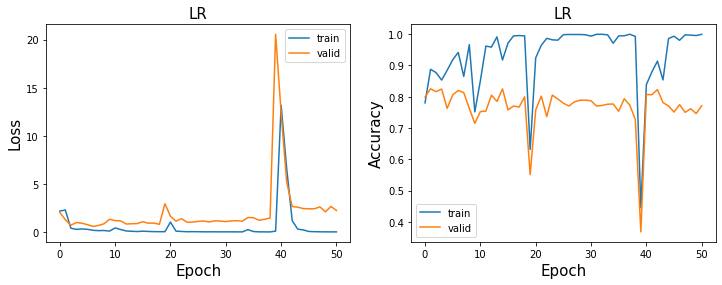

In [5]:
best_epoch, min_val_loss = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)

val loss:0.5865116715431213, val accuracy:0.8198931569575172, val percentage postive:0.7914016842842102


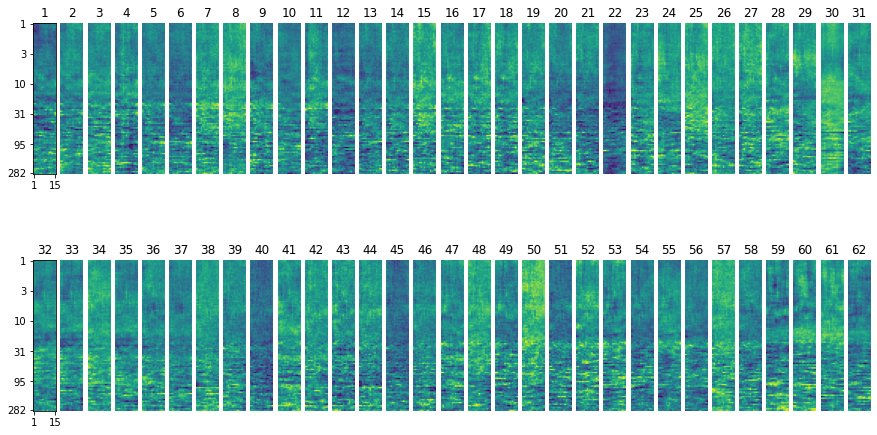

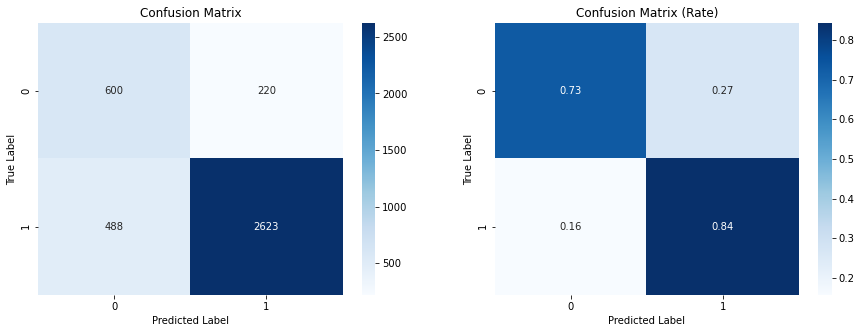

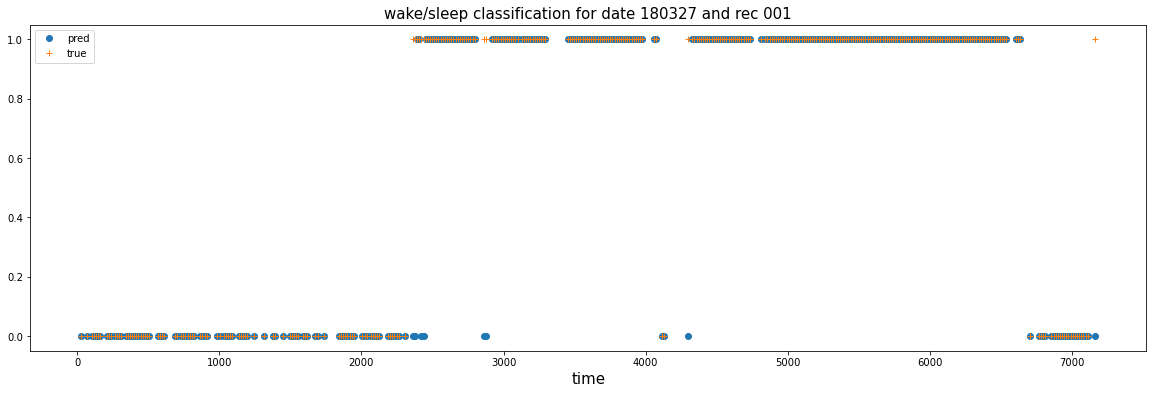

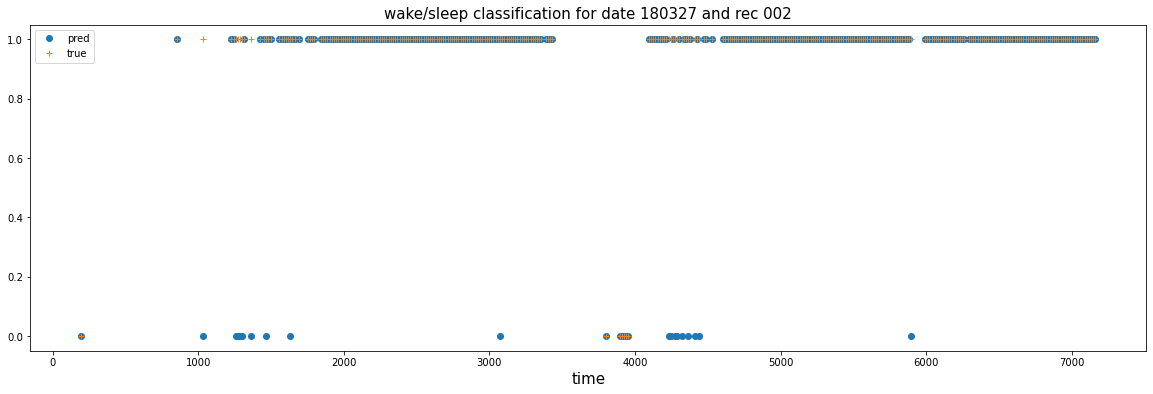

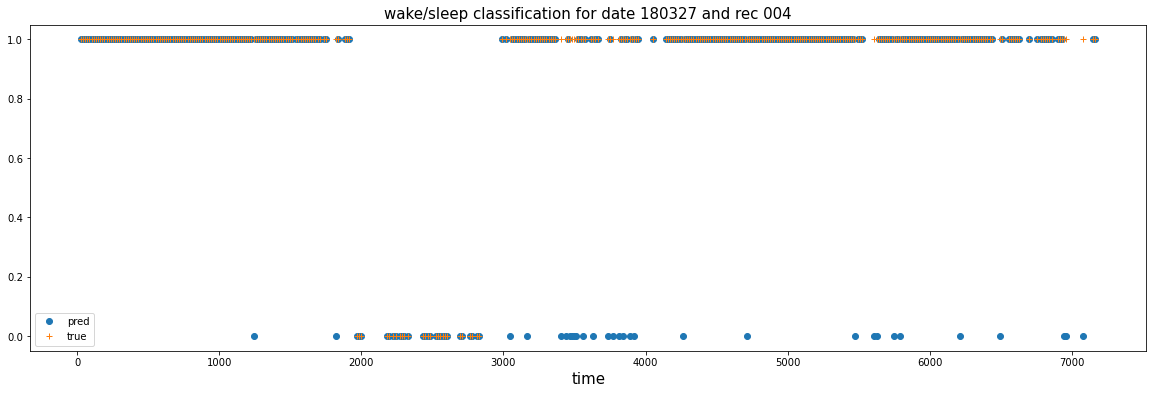

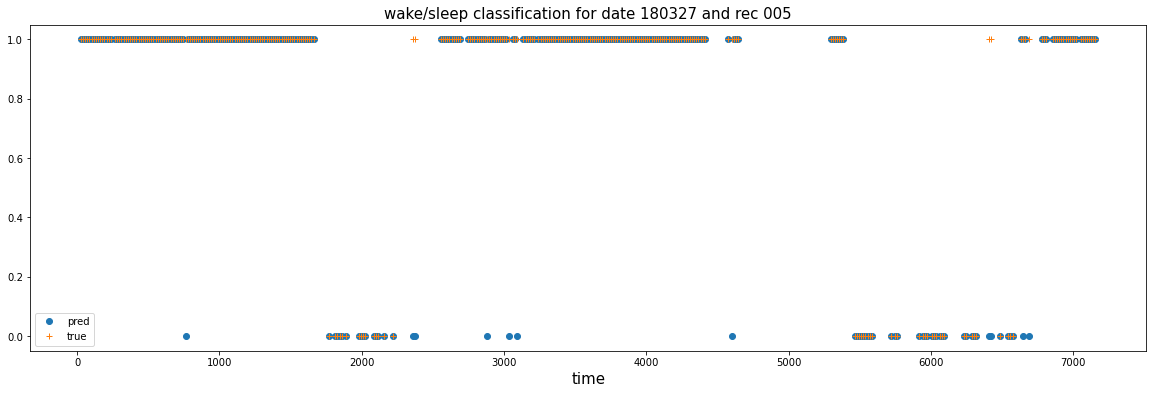

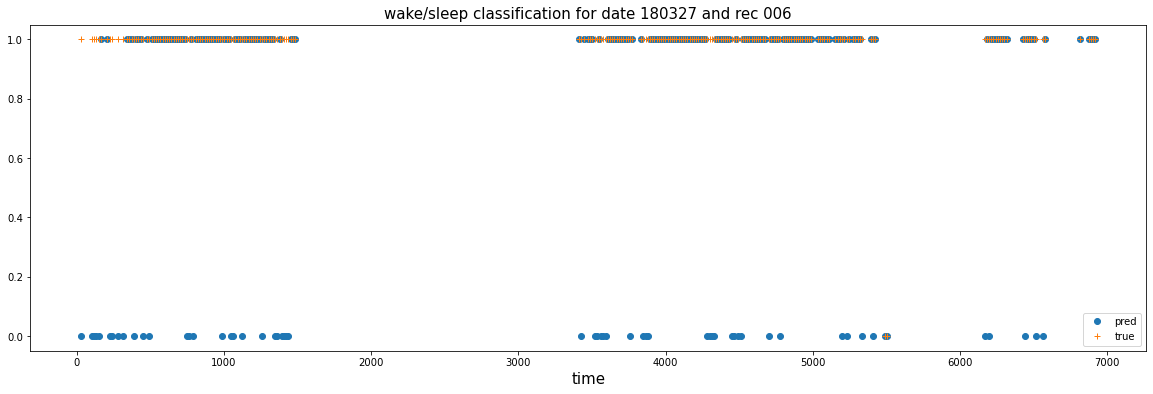

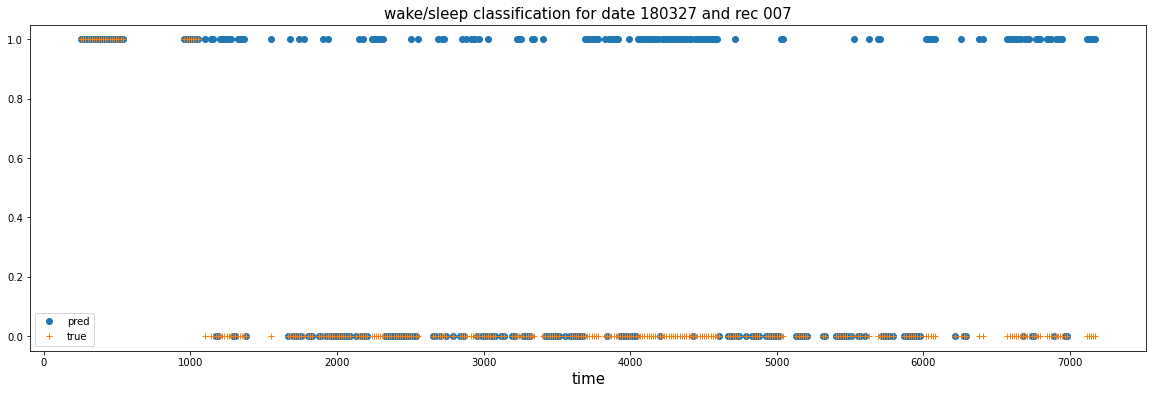

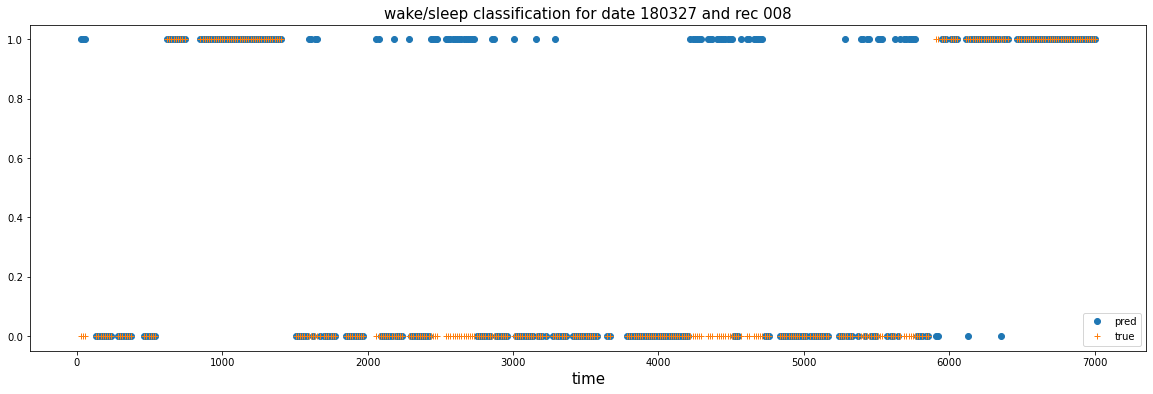

In [6]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.014036433771252632, train accuracy:0.9991232265263829, train percentage postive:0.5


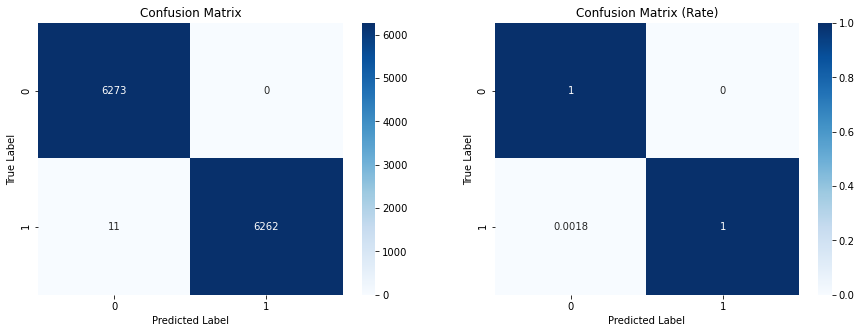

In [7]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With L2 regularization

In [8]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'l2'

0
Train loss for epoch 0: 4.18635892868042
Val loss for epoch 0: 1.495126485824585
2
Train loss for epoch 2: 0.9616124629974365
Val loss for epoch 2: 0.9895066022872925
3
Train loss for epoch 3: 0.3779781460762024
Val loss for epoch 3: 0.9712028503417969
4
Train loss for epoch 4: 0.33116215467453003
Val loss for epoch 4: 0.6490052342414856


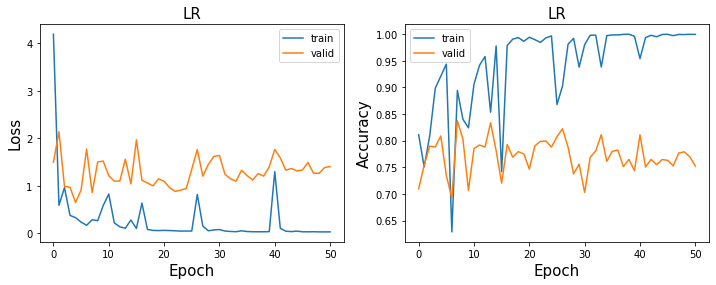

0
Train loss for epoch 0: 8.425651550292969
Val loss for epoch 0: 3.166980266571045
1
Train loss for epoch 1: 1.1299889087677002
Val loss for epoch 1: 1.4886730909347534
2
Train loss for epoch 2: 0.7266862392425537
Val loss for epoch 2: 0.819179117679596
3
Train loss for epoch 3: 0.5756561160087585
Val loss for epoch 3: 0.5790748000144958
7
Train loss for epoch 7: 1.0230635404586792
Val loss for epoch 7: 0.5294300317764282
11
Train loss for epoch 11: 0.5324495434761047
Val loss for epoch 11: 0.4488365650177002
31
Train loss for epoch 31: 0.5165221095085144
Val loss for epoch 31: 0.4394189119338989


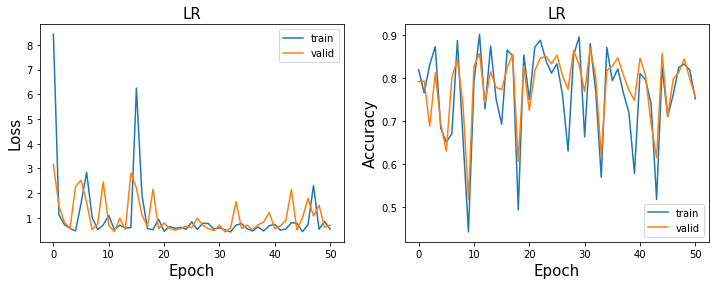

0
Train loss for epoch 0: 4.747492790222168
Val loss for epoch 0: 1.965370535850525
1
Train loss for epoch 1: 1.0314204692840576
Val loss for epoch 1: 1.218561053276062
2
Train loss for epoch 2: 0.8701249957084656
Val loss for epoch 2: 1.05563485622406
3
Train loss for epoch 3: 0.9532648921012878
Val loss for epoch 3: 0.7972727417945862
6
Train loss for epoch 6: 1.457907795906067
Val loss for epoch 6: 0.6128353476524353
11
Train loss for epoch 11: 1.6580681800842285
Val loss for epoch 11: 0.5443994402885437
13
Train loss for epoch 13: 0.6458330750465393
Val loss for epoch 13: 0.43643882870674133


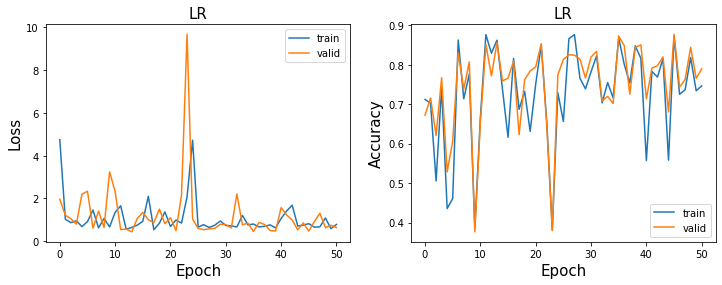

In [9]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.43643882870674133, val accuracy:0.8560162808445688, val percentage postive:0.7914016842842102


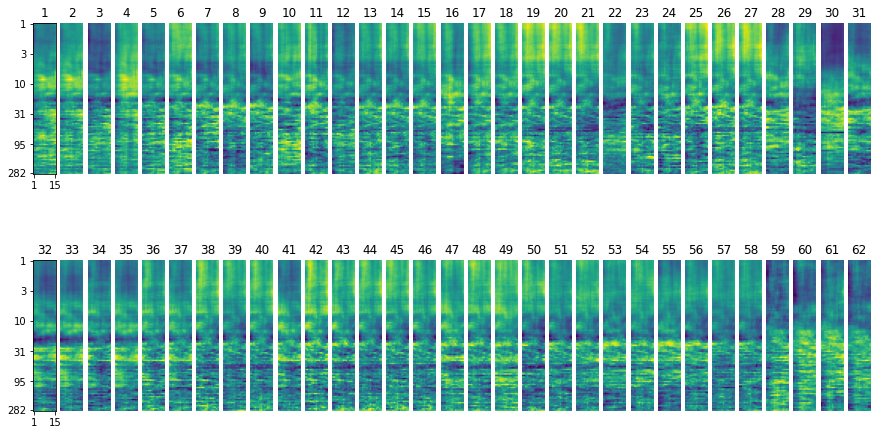

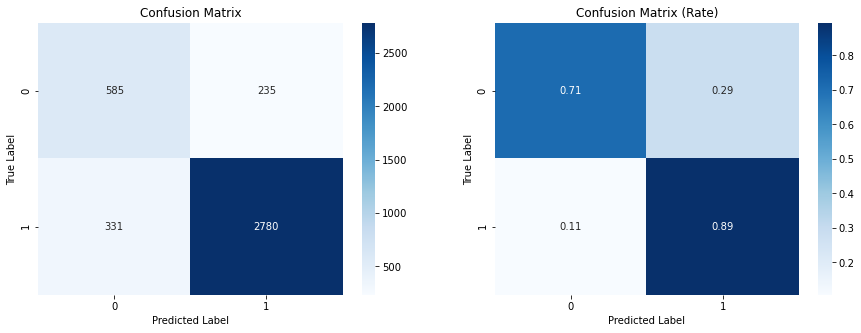

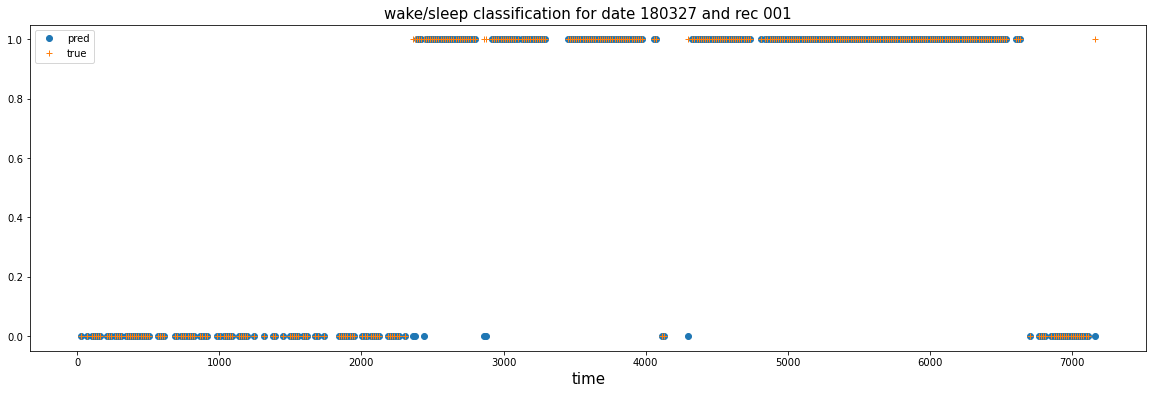

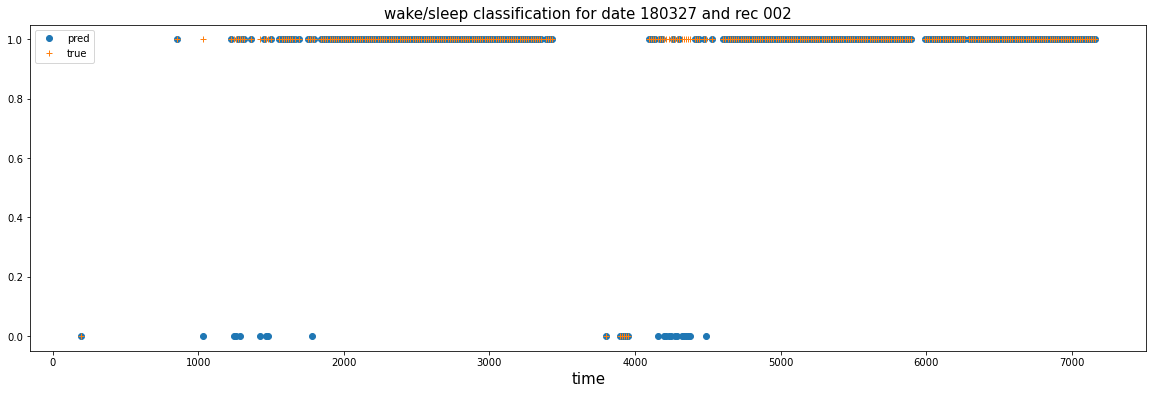

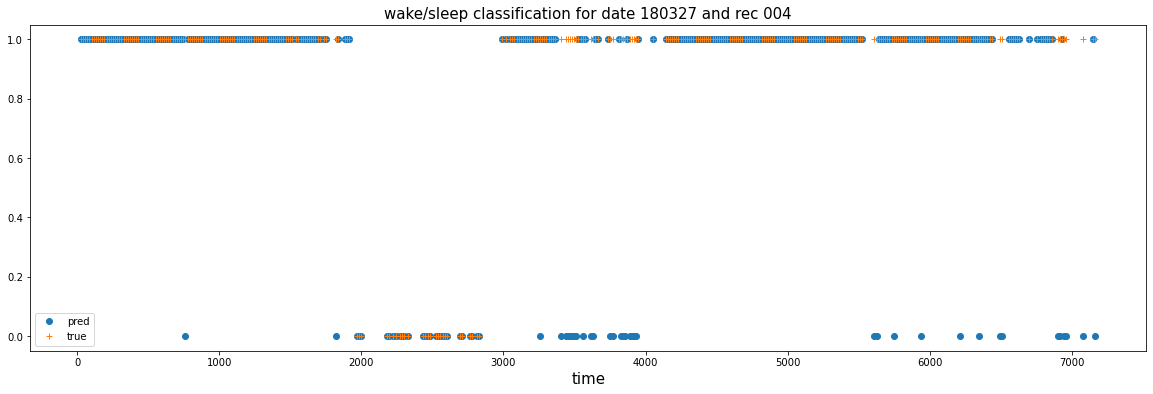

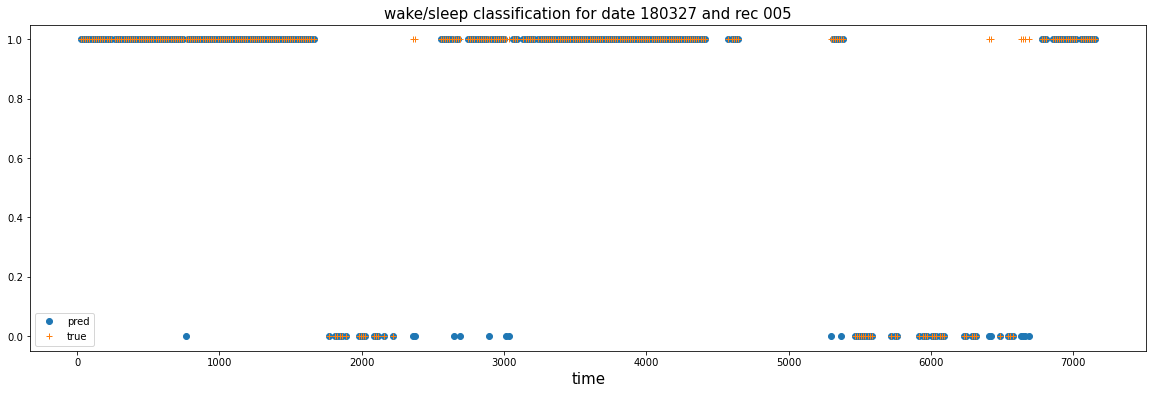

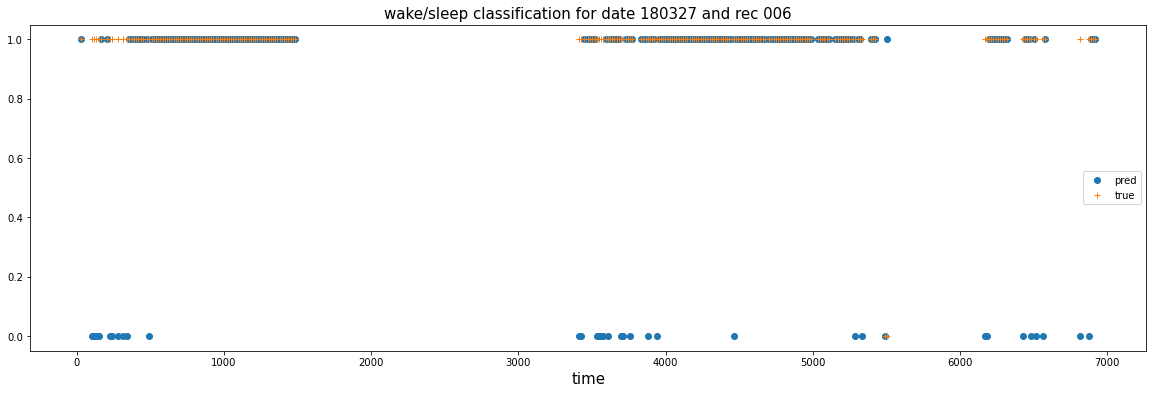

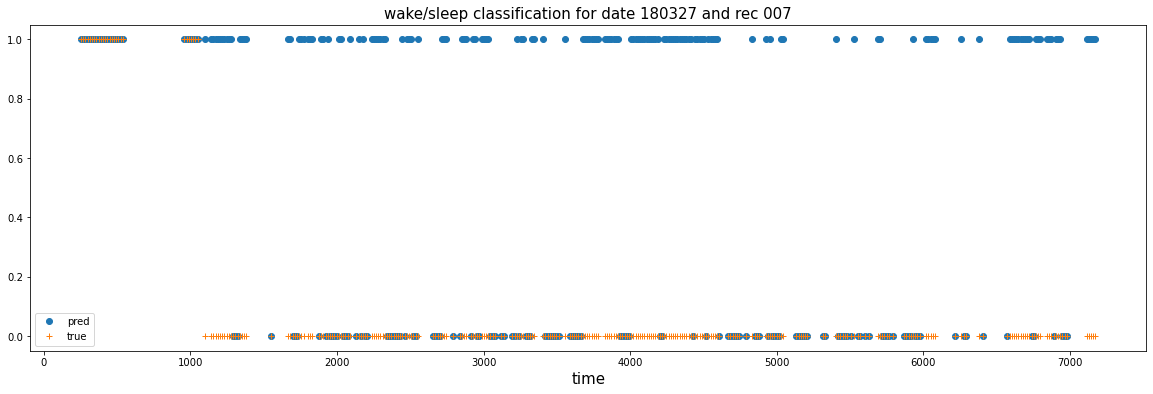

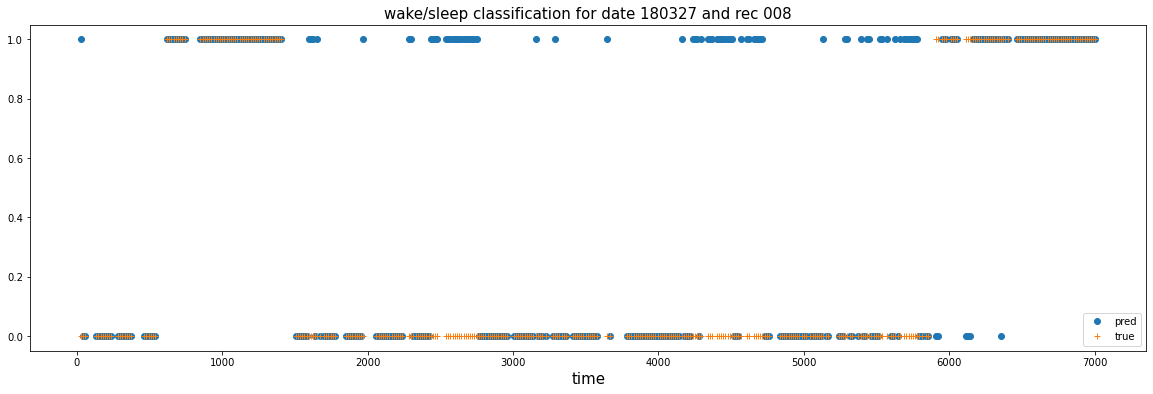

In [10]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:0.7459688186645508, train accuracy:0.7466124661246613, train percentage postive:0.5


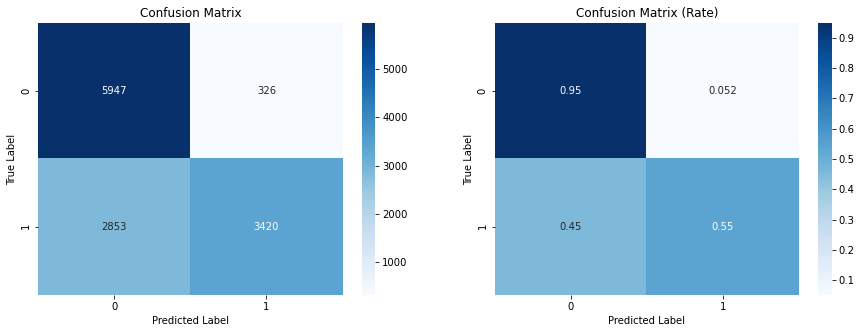

In [11]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)

#### With finite difference regularization

In [12]:
learning_rate = 0.001
num_epochs = 51
alpha = 100
model_type = 'LR'
loss_type = 'bce'
reg_type = 'finite_diff'

0
Train loss for epoch 0: 1.7960902452468872
Val loss for epoch 0: 0.7056350708007812


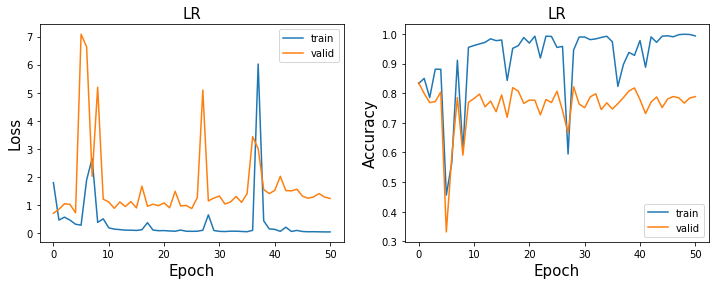

0
Train loss for epoch 0: 3.7273643016815186
Val loss for epoch 0: 1.680069088935852
1
Train loss for epoch 1: 1.2931594848632812
Val loss for epoch 1: 1.0159194469451904
2
Train loss for epoch 2: 0.6958746910095215
Val loss for epoch 2: 0.9251020550727844
3
Train loss for epoch 3: 0.8458099365234375
Val loss for epoch 3: 0.8352125287055969
7
Train loss for epoch 7: 0.6420785188674927
Val loss for epoch 7: 0.7534386515617371


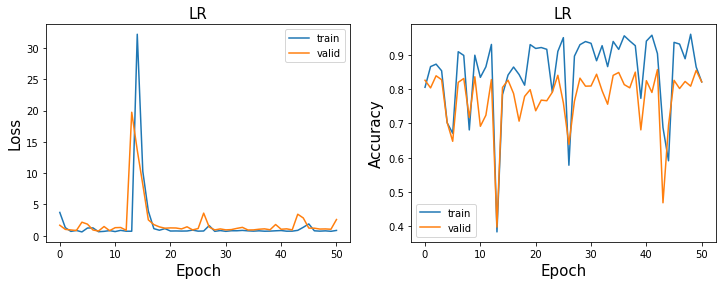

0
Train loss for epoch 0: 4.20173454284668
Val loss for epoch 0: 3.56630539894104
1
Train loss for epoch 1: 2.437791109085083
Val loss for epoch 1: 2.3489346504211426
2
Train loss for epoch 2: 3.4198555946350098
Val loss for epoch 2: 1.4765642881393433
3
Train loss for epoch 3: 1.096971035003662
Val loss for epoch 3: 1.149661660194397


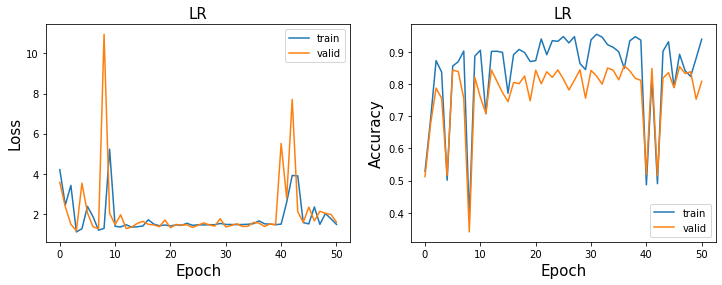

In [13]:
min_val_loss = 100
for alpha in [1, 50, 100]:
    model = GLM(input_dim=100*time_window*62).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    best_epoch_alpha, min_val_loss_alpha = tuning(train_loader, val_loader, model, optimizer, device, num_epochs, alpha, model_type, loss_type, reg_type, CH, save_path, timewindow=time_window)
    if min_val_loss_alpha < min_val_loss:
        min_val_loss = min_val_loss_alpha
        best_epoch = best_epoch_alpha
        best_alpha = alpha

val loss:0.7056350708007812, val accuracy:0.8354108369371661, val percentage postive:0.7914016842842102


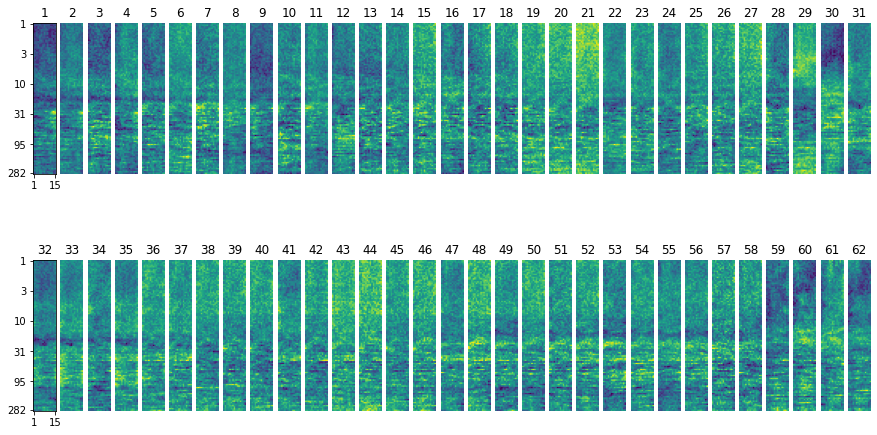

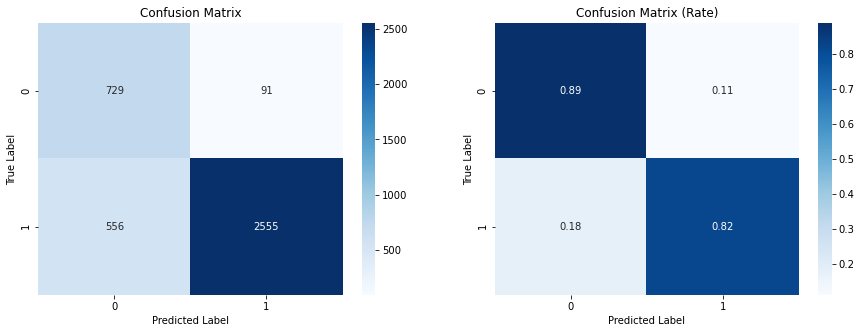

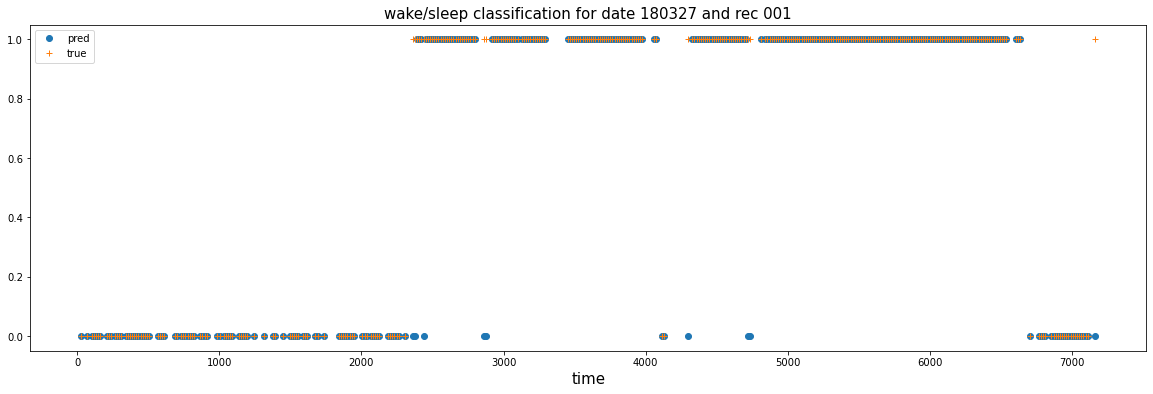

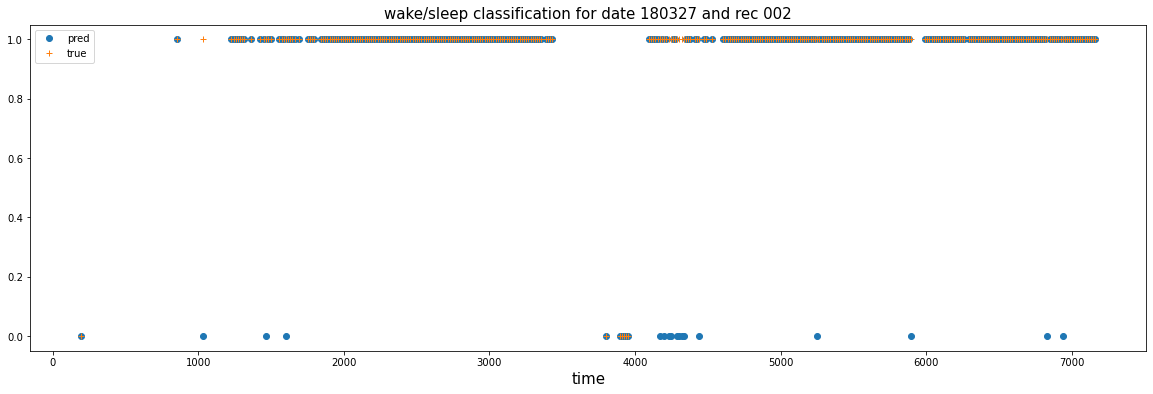

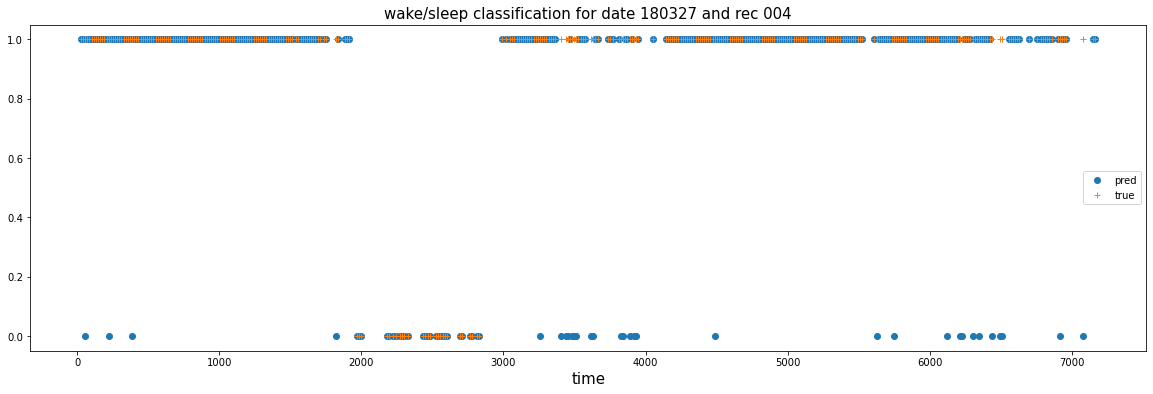

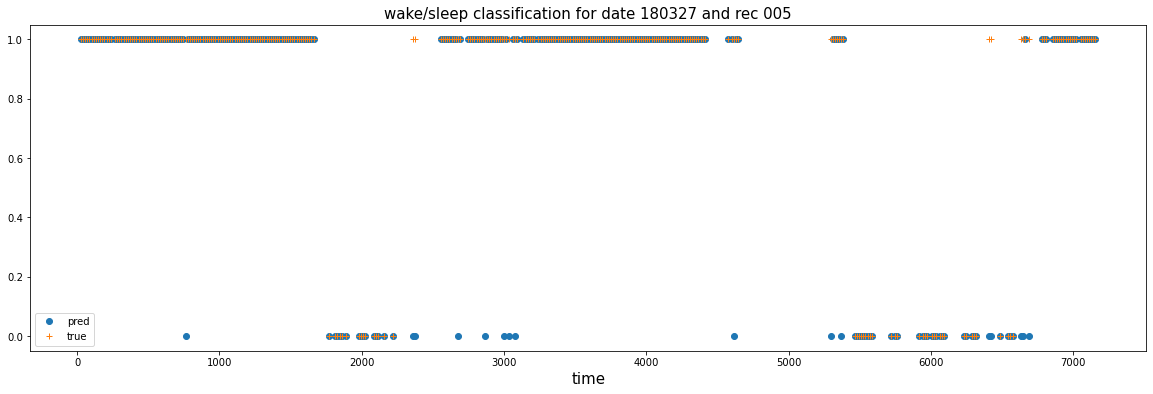

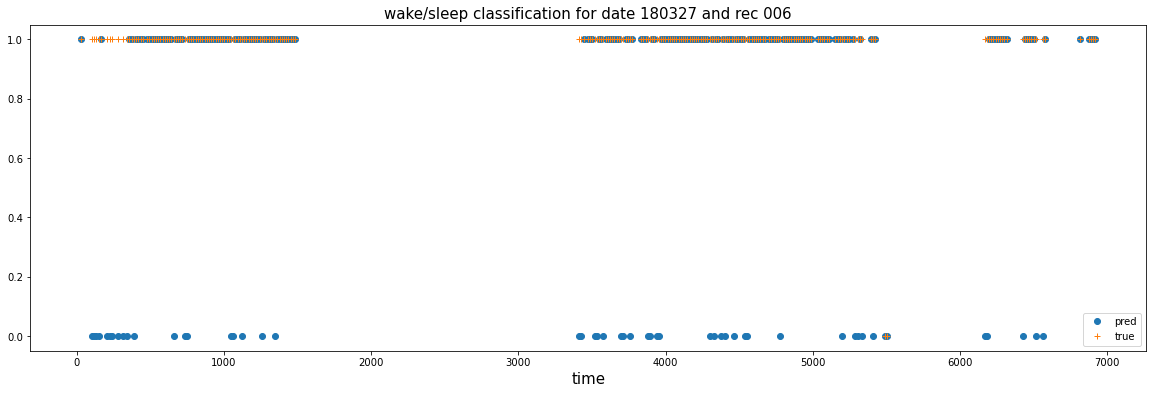

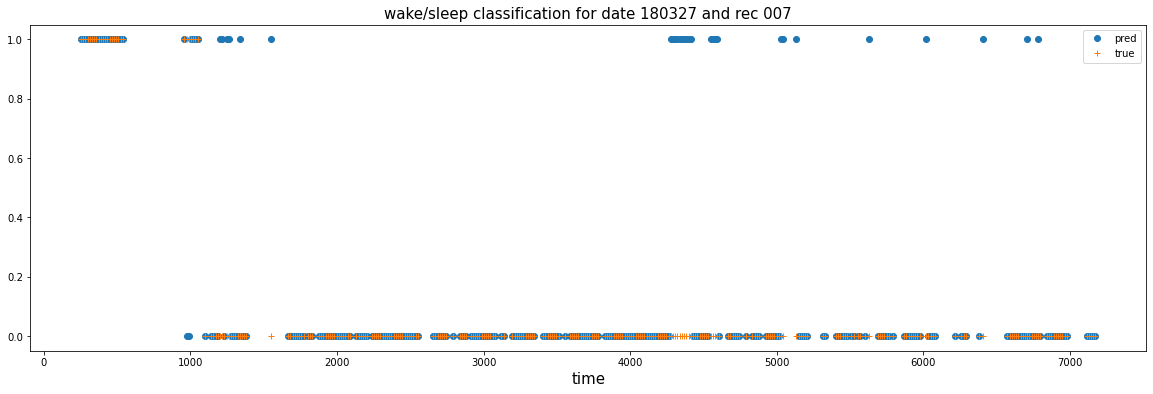

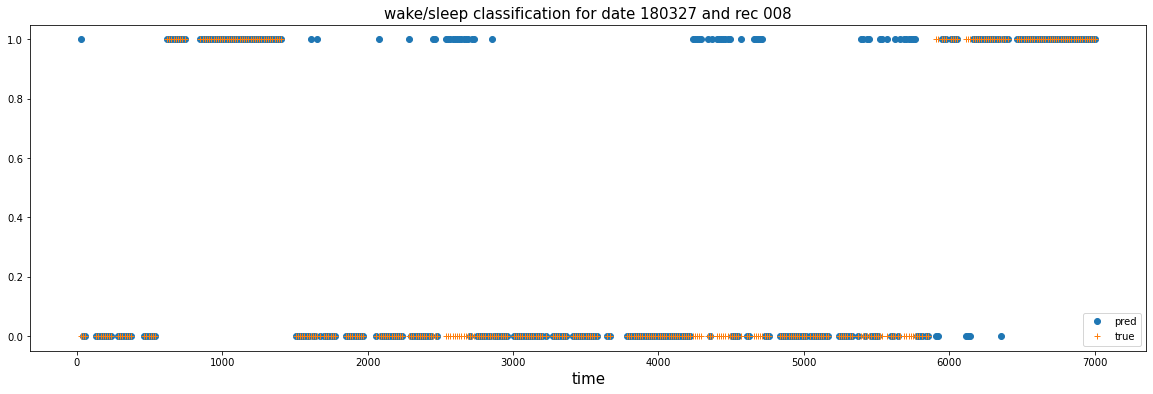

In [14]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, best_epoch)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

val_loss, val_acc, val_preds, val_preds_probs, val_labels, val_ds, val_rs, val_ts, cases_wrong_val = evaluate(model, optimizer, val_loader, alpha=best_alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('val loss:{}, val accuracy:{}, val percentage postive:{}'.format(val_loss, val_acc, np.mean(np.concatenate(val_labels))))
plot_weight_glm(device, save_path, model_type, CH, loss_type, reg_type, best_alpha, best_epoch, timewindow=time_window)
plot_confusion(val_preds, val_labels)
plot_pred_vs_true(val_preds, val_labels, val_ds, val_rs, val_ts, date_1=val_dates[0])

train loss:1.9975062608718872, train accuracy:0.9931452255699028, train percentage postive:0.5


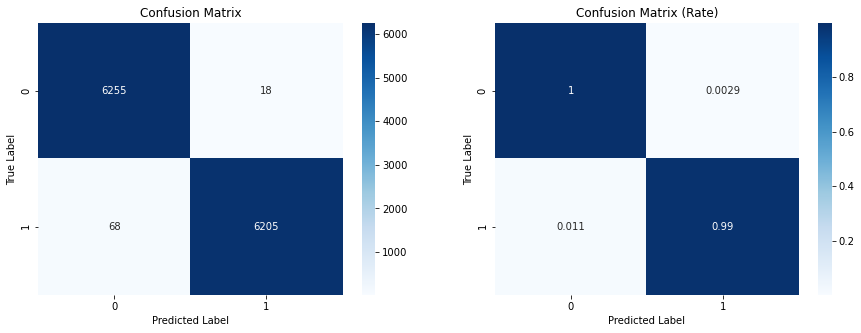

In [15]:
model = GLM(input_dim=100*time_window*62).to(device)
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(save_path, model_type, CH, loss_type, reg_type, best_alpha, time_window, num_epochs-1)))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_loss, train_acc, train_preds, train_preds_probs, train_labels, _, _, _, cases_wrong_train = evaluate(model, optimizer, train_loader, alpha=alpha, timewindow=time_window, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('train loss:{}, train accuracy:{}, train percentage postive:{}'.format(train_loss, train_acc, np.mean(np.concatenate(train_labels))))
plot_confusion(train_preds, train_labels)